
# California Wildfire Prediction

Techlabs Düsseldorf Summer 2021

*Team: Annabel, Iffat & Lena*

The goal of this project is to attempt to predict wildfires in California given data such as location, day of week and so on, as well as meteorological data.
<br> We start with cleaning the datasets of fire and weather, then gaining an overview over both, combining them and then focus on the machine learning predictions.
<br> The fire dataset, an SQLite file, is taken from Kaggle (188 Million U.S. Wildfires; https://www.kaggle.com/rtatman/188-million-us-wildfires).
<br> Meteorological data was taken from NOAA as well as from ERA5 (Copernicus; https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview).

**Part 1: Data Loading and Exploration - Fire**

> Part 1.1: Exploratory Data Analysis - Fire 

> Part 1.2: Exploratory Data Analysis - Fire - California Only


**Part 2: Data Loading and Exploration - Weather**

> Part 2.1: NOAA Weather Data

> Part 2.2: ERA5 Weather Data (Copernicus)


**Part 3: Machine Learning**

> Part 3.1: Predicting Fire Size & Frequency with Fire Data only

> Part 3.2: Predicting Fires Size and Frequency with Fire & Weather Data

**Summary & Outlook**

In [1]:
# Loading all relevant packages
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import seaborn as sns
import xarray as xr               # make sure xarray is installed in your general anaconda/python environment!

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## Part 1: Data Loading and Exploration - Fire

First we need to establish a connection with the database file.

In [2]:
conn = sqlite3.connect('C:\\Users\\avrol\\Desktop\\TechLabs\\Wildfires\\KaggleUS\\FPA_FOD_20170508.sqlite')

We take a look at the general information of the dataset to obtain an overview:

In [3]:
df_overview = pd.read_sql_query("SELECT * FROM Fires;", conn)
df_overview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 39 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   OBJECTID                    int64  
 1   FOD_ID                      int64  
 2   FPA_ID                      object 
 3   SOURCE_SYSTEM_TYPE          object 
 4   SOURCE_SYSTEM               object 
 5   NWCG_REPORTING_AGENCY       object 
 6   NWCG_REPORTING_UNIT_ID      object 
 7   NWCG_REPORTING_UNIT_NAME    object 
 8   SOURCE_REPORTING_UNIT       object 
 9   SOURCE_REPORTING_UNIT_NAME  object 
 10  LOCAL_FIRE_REPORT_ID        object 
 11  LOCAL_INCIDENT_ID           object 
 12  FIRE_CODE                   object 
 13  FIRE_NAME                   object 
 14  ICS_209_INCIDENT_NUMBER     object 
 15  ICS_209_NAME                object 
 16  MTBS_ID                     object 
 17  MTBS_FIRE_NAME              object 
 18  COMPLEX_NAME                object 
 19  FIRE_YEAR            

Now we can create our data frame by running a select query on the database. <br> The table of interest to us is called 'Fires' and we decided to import the following columns:

In [4]:
query = '''
        SELECT 
            FIRE_YEAR,
            STAT_CAUSE_DESCR,
            LATITUDE,
            LONGITUDE,
            STATE,
            COUNTY,
            DISCOVERY_DATE,
            DISCOVERY_DOY,
            FIRE_SIZE
        FROM 
            Fires
         '''
df = pd.read_sql_query(query, conn)
print(df.head()) #check the data

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE COUNTY  \
0       2005    Miscellaneous  40.036944 -121.005833    CA     63   
1       2004        Lightning  38.933056 -120.404444    CA     61   
2       2004   Debris Burning  38.984167 -120.735556    CA     17   
3       2004        Lightning  38.559167 -119.913333    CA      3   
4       2004        Lightning  38.559167 -119.933056    CA      3   

   DISCOVERY_DATE  DISCOVERY_DOY  FIRE_SIZE  
0       2453403.5             33       0.10  
1       2453137.5            133       0.25  
2       2453156.5            152       0.10  
3       2453184.5            180       0.10  
4       2453184.5            180       0.10  


The loaded dataset contains the following columns (variables):

    - FIRE_YEAR: Year of the fire
    - STAT_CAUSE_DESCR: Cause of the fire
    - LATITUDE
    - LONGITUDE
    - STATE: Data across all US States
    - DISCOVERY_DATE: This one needs to be changed to Gregorian format & to be droped later on
    - DISCOVERY_DOY: Day of the year (1 to 366)
    - FIRE_SIZE: Estimate of acres within the final perimeter of the fire
    
From this we want to calculate the following variables:
    - DATE 
    - MONTH
    - DAY_OF_WEEK
    - DAY
    

The DISCOVERY_DATE field is in Julian Date format.
<br> In the interest of greater clarity, we convert this field to Gregorian dates - the date format we use everyday.
<br> In the next step, we use it to generate the additional columns 'MONTH', 'DAY' and 'DAY_OF_WEEK'.

In [5]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
print(df.head()) # check the data

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE COUNTY  \
0       2005    Miscellaneous  40.036944 -121.005833    CA     63   
1       2004        Lightning  38.933056 -120.404444    CA     61   
2       2004   Debris Burning  38.984167 -120.735556    CA     17   
3       2004        Lightning  38.559167 -119.913333    CA      3   
4       2004        Lightning  38.559167 -119.933056    CA      3   

   DISCOVERY_DATE  DISCOVERY_DOY  FIRE_SIZE       DATE  
0       2453403.5             33       0.10 2005-02-02  
1       2453137.5            133       0.25 2004-05-12  
2       2453156.5            152       0.10 2004-05-31  
3       2453184.5            180       0.10 2004-06-28  
4       2453184.5            180       0.10 2004-06-28  


In [6]:
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY'] = pd.DatetimeIndex(df['DATE']).day
df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()        

print(df.head()) #check the data

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE COUNTY  \
0       2005    Miscellaneous  40.036944 -121.005833    CA     63   
1       2004        Lightning  38.933056 -120.404444    CA     61   
2       2004   Debris Burning  38.984167 -120.735556    CA     17   
3       2004        Lightning  38.559167 -119.913333    CA      3   
4       2004        Lightning  38.559167 -119.933056    CA      3   

   DISCOVERY_DATE  DISCOVERY_DOY  FIRE_SIZE       DATE  MONTH  DAY DAY_OF_WEEK  
0       2453403.5             33       0.10 2005-02-02      2    2   Wednesday  
1       2453137.5            133       0.25 2004-05-12      5   12   Wednesday  
2       2453156.5            152       0.10 2004-05-31      5   31      Monday  
3       2453184.5            180       0.10 2004-06-28      6   28      Monday  
4       2453184.5            180       0.10 2004-06-28      6   28      Monday  


In [7]:
df = df[df.columns.drop('DISCOVERY_DATE')]
print(df.head()) #check the data

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE COUNTY  \
0       2005    Miscellaneous  40.036944 -121.005833    CA     63   
1       2004        Lightning  38.933056 -120.404444    CA     61   
2       2004   Debris Burning  38.984167 -120.735556    CA     17   
3       2004        Lightning  38.559167 -119.913333    CA      3   
4       2004        Lightning  38.559167 -119.933056    CA      3   

   DISCOVERY_DOY  FIRE_SIZE       DATE  MONTH  DAY DAY_OF_WEEK  
0             33       0.10 2005-02-02      2    2   Wednesday  
1            133       0.25 2004-05-12      5   12   Wednesday  
2            152       0.10 2004-05-31      5   31      Monday  
3            180       0.10 2004-06-28      6   28      Monday  
4            180       0.10 2004-06-28      6   28      Monday  


### Part 1.1: Exploratory Data Analysis - Fire

This data still contains information for all Amercian states. We are going to explore the full dataset first, out of interest and for general familiarization with the situation of fires in the U.S.. Later on, we will then drop data for all states but California and focus on the situation there. 

But first - let's get started with the basics & explore some of our data's basic features to get to know it better!

In [8]:
print(df.shape)

(1880465, 12)


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   FIRE_YEAR         int64         
 1   STAT_CAUSE_DESCR  object        
 2   LATITUDE          float64       
 3   LONGITUDE         float64       
 4   STATE             object        
 5   COUNTY            object        
 6   DISCOVERY_DOY     int64         
 7   FIRE_SIZE         float64       
 8   DATE              datetime64[ns]
 9   MONTH             int64         
 10  DAY               int64         
 11  DAY_OF_WEEK       object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 172.2+ MB
None


Find out how many null/NaN values the columns have:

In [10]:
print(df.isnull().sum())

FIRE_YEAR                0
STAT_CAUSE_DESCR         0
LATITUDE                 0
LONGITUDE                0
STATE                    0
COUNTY              678148
DISCOVERY_DOY            0
FIRE_SIZE                0
DATE                     0
MONTH                    0
DAY                      0
DAY_OF_WEEK              0
dtype: int64


> 678148 datapoints are missing in the 'COUNTY' column, the rest is complete. Later on we will whether this is still an issue for California.

Now we want to find out more about the timeframe our dataset covers.

In [11]:
# Minimal Date in the Dataframe
print(min(df['DATE']))

1992-01-01 00:00:00


In [12]:
# Maximum Date in the Dataframe
print(max(df['DATE']))

2015-12-31 00:00:00


> Our Fire dataset contains data from 01 Jan 1992 to 31 Dec 2015.

Let's check whether Latitude and Longitude really cover the United States.

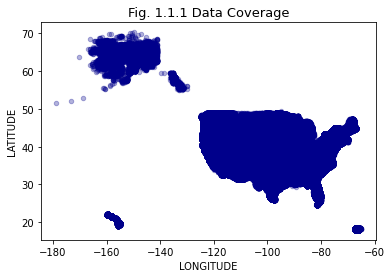

In [13]:
df.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',color='darkblue',alpha=0.3)
counter_fig = '1.1.1'
plt.title(f'Fig. {counter_fig} Data Coverage', fontsize=13)
plt.show()

> This map looks pretty much like the United States and very much complete as well.

Next we want to look at the causes of the fires as described in the dataset.

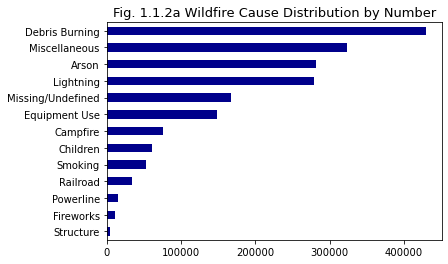

In [14]:
df['STAT_CAUSE_DESCR'].value_counts().sort_values(ascending=True).plot(kind='barh',color='darkblue')
counter_fig = '1.1.2a'
plt.title(f'Fig. {counter_fig} Wildfire Cause Distribution by Number', fontsize=13)
plt.show()

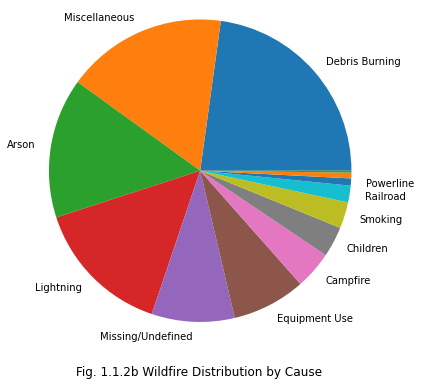

In [15]:
# Alternative plotting of the chart above

distribution = df['STAT_CAUSE_DESCR'].value_counts()
plt.figure(figsize=(6,6))
plt.title('Fig. 1.1.2b Wildfire Distribution by Cause', y=-0.15)
plt.pie(distribution, labels=list(distribution.index[:-2]) + ['', ''])
plt.axis('equal');

> There are 13 causes listed in the dataset. The only real 'natural' cause of Lightning is among the most common causes of fires in the U.S.. <br> Yet, meteorological factors can influence all of them by facilitating fire growth through dry conditions. 

Next we want to check whether fires are more likely on certain days of the week.

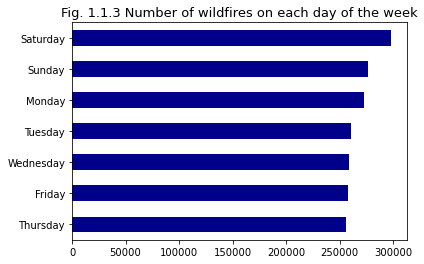

In [16]:
df['DAY_OF_WEEK'].value_counts().sort_values(ascending=True).plot(kind='barh',color='darkblue')
counter_fig='1.1.3'
plt.title(f'Fig. {counter_fig} Number of wildfires on each day of the week', fontsize=13)
plt.show()

> Fires are slightly more likely to start/be discovered on the weekend. This can very much be due to people being careless with campfires or smoking or possibly malicious fires. It seems unrealistic that fires due to natural causes such as lightning would increase at the weekend. 

But let's test that:

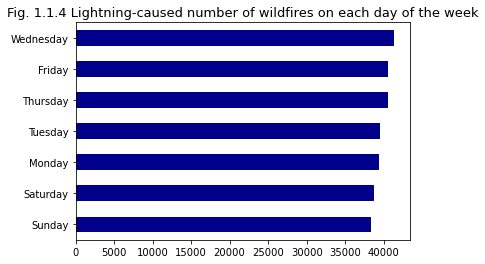

In [17]:
df_lightning = df[df['STAT_CAUSE_DESCR']=='Lightning']
df_lightning['DAY_OF_WEEK'].value_counts(ascending=True).plot(kind='barh',color='darkblue')
counter_fig='1.1.4'
plt.title(f'Fig. {counter_fig} Lightning-caused number of wildfires on each day of the week', fontsize=13)
plt.show()

> There is some variation but now the weekend is a less frequent time for fire detection. 

Is the general increase at the weekend due to malicious fires - Arson:

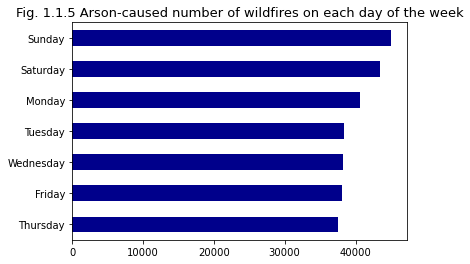

In [18]:
df_arson = df[df['STAT_CAUSE_DESCR']=='Arson']
df_arson['DAY_OF_WEEK'].value_counts(ascending=True).plot(kind='barh',color='darkblue')
counter_fig='1.1.5'
plt.title(f'Fig. {counter_fig} Arson-caused number of wildfires on each day of the week', fontsize=13)
plt.show()

> This shows a more significant trend - Arson is more likely at the weekend than during the week.

We're adding another column containing information about the summed wildfire sizes and investigate the evolution of the annually total area burned.

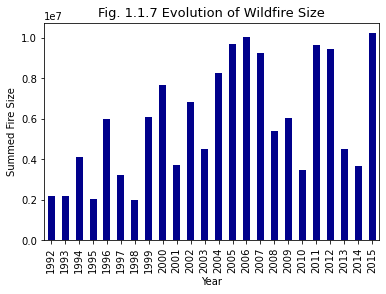

In [19]:
df_evolution = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, FIRE_YEAR FROM Fires GROUP BY FIRE_YEAR;", conn)
df_evolution.set_index("FIRE_YEAR").plot(kind='bar', color='darkblue', title='Wildfire Size Evolution', xlabel='Year', ylabel='Summed Fire Size', legend=None)
counter_fig='1.1.7'
plt.title(f'Fig. {counter_fig} Evolution of Wildfire Size', fontsize=13)
plt.show()

> Looking at the evolution of the annually summed fire sizes, we observe an upwards trend. The intensity of the wildfires across the U.S. has grown in the last couple of decades. The number of wildfires is increasing & they're burning more land.
<br> We suspect climate change is fueling wildfires as the rising temperatures lead to an earlier snowmelt, resulting in drier conditions and consequently favoring the increase of the total area burned.

In which state do the most fires occur? In order to avoid an oversized graph we show the top ten states only.

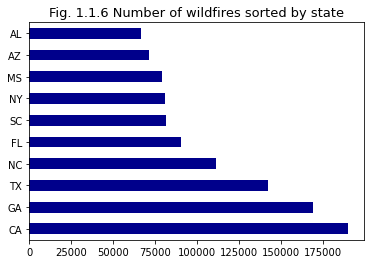

In [20]:
df['STATE'].value_counts().head(n=10).plot(kind='barh',color='darkblue')
counter_fig='1.1.6'
plt.title(f'Fig. {counter_fig} Number of wildfires sorted by state', fontsize=13)
plt.show()

> California is the state with the highest number of fires - that's a main reason, why we want to focus on this big and populous state, being associated with a dry climate. It is followed by Georgia and Texas. 

### Part 1.2: Exploratory Data Analysis - Fire - California Only

In [21]:
# Extract California Data
df_CA = df[df['STATE']=='CA']

After extracting only Californian datapoints, we want to check the basics of the dataframe again:

In [22]:
print(df_CA.shape)

(189550, 12)


In [23]:
print(df_CA.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE COUNTY  \
0       2005    Miscellaneous  40.036944 -121.005833    CA     63   
1       2004        Lightning  38.933056 -120.404444    CA     61   
2       2004   Debris Burning  38.984167 -120.735556    CA     17   
3       2004        Lightning  38.559167 -119.913333    CA      3   
4       2004        Lightning  38.559167 -119.933056    CA      3   

   DISCOVERY_DOY  FIRE_SIZE       DATE  MONTH  DAY DAY_OF_WEEK  
0             33       0.10 2005-02-02      2    2   Wednesday  
1            133       0.25 2004-05-12      5   12   Wednesday  
2            152       0.10 2004-05-31      5   31      Monday  
3            180       0.10 2004-06-28      6   28      Monday  
4            180       0.10 2004-06-28      6   28      Monday  


In [24]:
print(df_CA.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189550 entries, 0 to 1880464
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   FIRE_YEAR         189550 non-null  int64         
 1   STAT_CAUSE_DESCR  189550 non-null  object        
 2   LATITUDE          189550 non-null  float64       
 3   LONGITUDE         189550 non-null  float64       
 4   STATE             189550 non-null  object        
 5   COUNTY            56221 non-null   object        
 6   DISCOVERY_DOY     189550 non-null  int64         
 7   FIRE_SIZE         189550 non-null  float64       
 8   DATE              189550 non-null  datetime64[ns]
 9   MONTH             189550 non-null  int64         
 10  DAY               189550 non-null  int64         
 11  DAY_OF_WEEK       189550 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 18.8+ MB
None


Check dataset for missing values:

In [25]:
print(df_CA.isnull().sum())

FIRE_YEAR                0
STAT_CAUSE_DESCR         0
LATITUDE                 0
LONGITUDE                0
STATE                    0
COUNTY              133329
DISCOVERY_DOY            0
FIRE_SIZE                0
DATE                     0
MONTH                    0
DAY                      0
DAY_OF_WEEK              0
dtype: int64


> County is a missing value for 133,329 entries out of 189,550. As this information is not essential to our project, we will delete it.

In [26]:
df_CA = df_CA[df_CA.columns.drop('COUNTY')]
print(df_CA.head()) #check the data

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DOY  \
0       2005    Miscellaneous  40.036944 -121.005833    CA             33   
1       2004        Lightning  38.933056 -120.404444    CA            133   
2       2004   Debris Burning  38.984167 -120.735556    CA            152   
3       2004        Lightning  38.559167 -119.913333    CA            180   
4       2004        Lightning  38.559167 -119.933056    CA            180   

   FIRE_SIZE       DATE  MONTH  DAY DAY_OF_WEEK  
0       0.10 2005-02-02      2    2   Wednesday  
1       0.25 2004-05-12      5   12   Wednesday  
2       0.10 2004-05-31      5   31      Monday  
3       0.10 2004-06-28      6   28      Monday  
4       0.10 2004-06-28      6   28      Monday  


Next we check whether the full timeframe is covered in the dataframe.

In [27]:
# Minimal Date in the California Dataframe
print(min(df_CA['DATE']))

1992-01-01 00:00:00


In [28]:
# Maximum Date in the California Dataframe
print(max(df_CA['DATE']))

2015-12-31 00:00:00


> The full timeframe is covered as in the whole dataset.

Next we want to ensure that the whole area of California is covered.

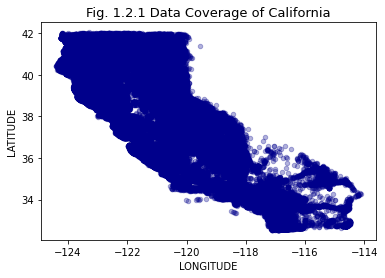

In [29]:
df_CA.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',color='darkblue',alpha=0.3)
counter_fig='1.2.1'
plt.title(f'Fig. {counter_fig} Data Coverage of California', fontsize=13)
plt.show()

> The vast region of California is covered and recognizable.

Again, we take a look at the different causes of fires, just as we did in the previous section when covering the whole country.

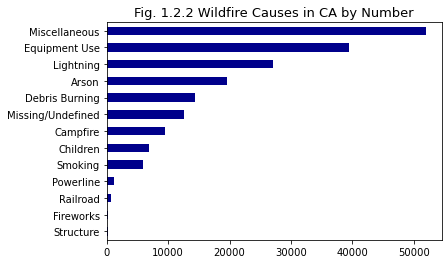

In [30]:
df_CA['STAT_CAUSE_DESCR'].value_counts().sort_values(ascending=True).plot(kind='barh',color='darkblue',title='Causes of Fires in CA')
counter_fig='1.2.2'
plt.title(f'Fig. {counter_fig} Wildfire Causes in CA by Number', fontsize=13)
plt.show()

We are also interested in seeing the general distribution of our data, so we check this visually.

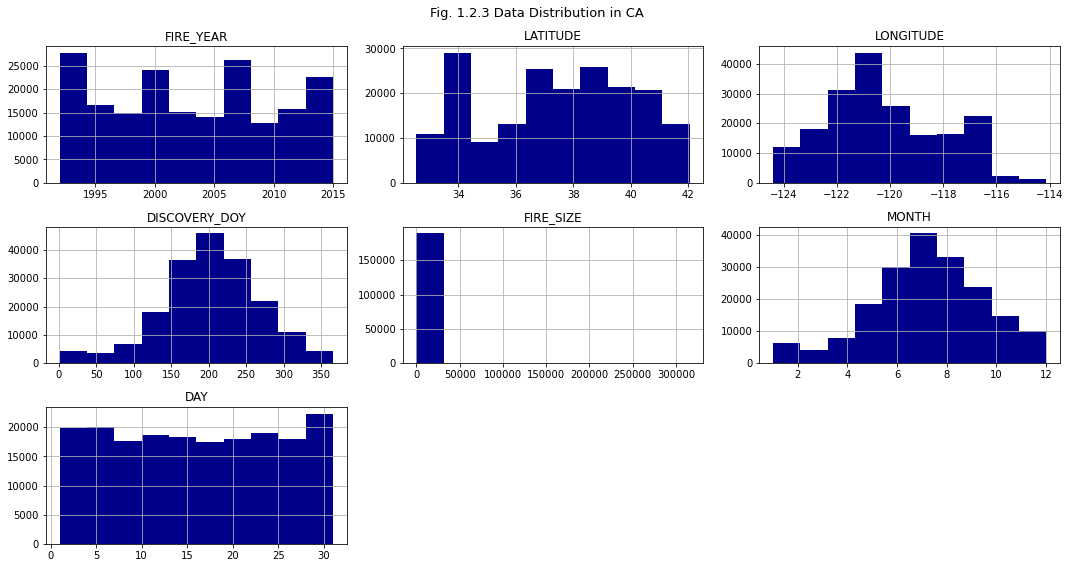

In [31]:
df_CA.hist(figsize=(15,8),color='darkblue')
plt.suptitle('Fig. 1.2.3 Data Distribution in CA', fontsize=13)
plt.subplots_adjust(top=0.88)
plt.tight_layout()

> We see that most distributions look plausible. While the cause distribution is not numerical and should not make sense, it is fine that way. The same is true for State, as we are only looking at California and this variable is not numerical at all. Actually, we could now get rid of this column.
> What strikes as unusual, though, is the distribution of Fire_Size. This needs to be checked in the following.

In [32]:
# Minimum Fire Size
print(min(df_CA['FIRE_SIZE']))

0.001


In [33]:
# Maximum Fire Size
print(max(df_CA['FIRE_SIZE']))

315578.8


Text(0.5, 1.0, 'Fig. 1.2.4 Fire Size Distribution in CA')

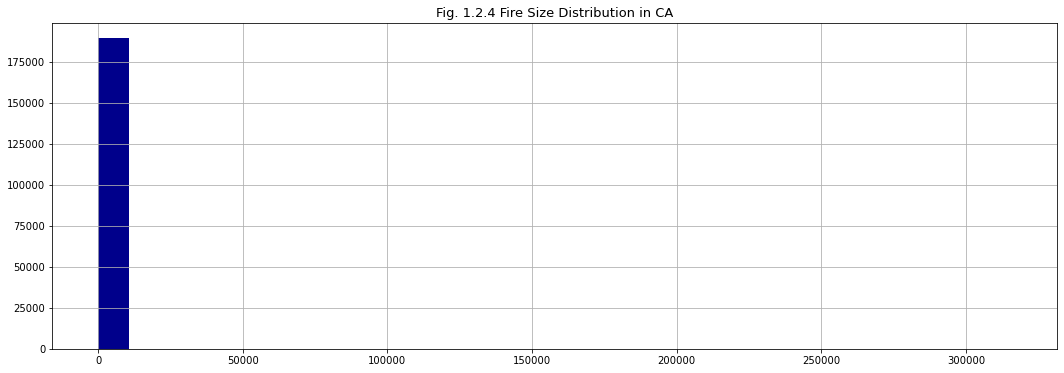

In [34]:
df_CA['FIRE_SIZE'].hist(figsize=(18, 6), bins=30, color='darkblue')
counter_fig='1.2.4'
plt.title(f'Fig. {counter_fig} Fire Size Distribution in CA', fontsize=13)

> Unfortunately, the graph is not very telling: there is a large number of small fires that stretches the y-axis, while there should be larger fires that are too few to spot them.

Next we try to split the graph up fourfold to improve our understanding of the large number of smaller fires and the low number of larger fires.

In [35]:
# Dividing the dataset into smaller chunks
CA_small = df_CA[df_CA["FIRE_SIZE"] < 1]
CA_medium = df_CA[(df_CA['FIRE_SIZE'] > 1) & (df_CA['FIRE_SIZE'] < 100)] 
CA_large = df_CA[(df_CA['FIRE_SIZE'] > 100) & (df_CA['FIRE_SIZE'] < 10000)]  
CA_xlarge = df_CA[df_CA["FIRE_SIZE"] > 10000]

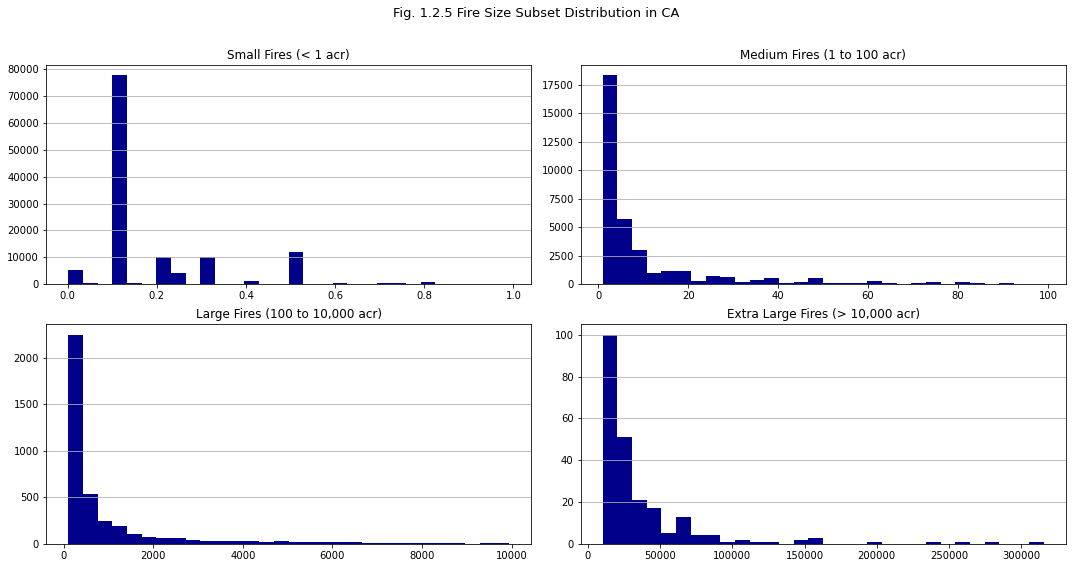

In [36]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

ax0.hist(CA_small['FIRE_SIZE'], bins=30, color='darkblue')
ax0.set_title('Small Fires (< 1 acr)')
ax0.grid(axis='y')

ax1.hist(CA_medium['FIRE_SIZE'], bins=30, color='darkblue')
ax1.set_title('Medium Fires (1 to 100 acr)')
ax1.grid(axis='y')

ax2.hist(CA_large['FIRE_SIZE'], bins=30, color='darkblue')
ax2.set_title('Large Fires (100 to 10,000 acr)')
ax2.grid(axis='y')

ax3.hist(CA_xlarge['FIRE_SIZE'], bins=30, color='darkblue')
ax3.set_title('Extra Large Fires (> 10,000 acr)')
ax3.grid(axis='y')

fig.tight_layout()
fig.suptitle('Fig. 1.2.5 Fire Size Subset Distribution in CA', fontsize=13)
fig.subplots_adjust(top=0.88)
plt.show()

In [37]:
df['FIRE_SIZE'].value_counts(ascending=True).sort_index(ascending=True)

0.00001          1
0.00009          1
0.00010         13
0.00020          4
0.00022          1
                ..
517078.00000     1
537627.00000     1
538049.00000     1
558198.30000     1
606945.00000     1
Name: FIRE_SIZE, Length: 13637, dtype: int64

> Apparently there is data in all subgraphs, just as expected. And every single graph shows a right skewed distribution.

This variable clearly needs to be transformed, e.g. by a logarithmic transformation. But first, we check for skew and kurtosis.

In [38]:
df_CA.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
FIRE_YEAR,0.038106,-1.218280
LATITUDE,-0.163687,-1.089595
LONGITUDE,0.312210,-0.756653
DISCOVERY_DOY,-0.341935,0.417006
FIRE_SIZE,82.812453,9288.836946
MONTH,-0.349440,0.374868
DAY,0.018061,-1.227345


> We can see that all variables are fairly symmetrical, as seen in the graph above, but Fire_Size clearly is not!

We transform the Fire_Size column using a log-transformation and adding '1+' so we don't receive any negative values as output.

In [39]:
df_CA.insert(len(df_CA.columns), 'FIRE_SIZE_log', np.log(1+df_CA['FIRE_SIZE']))

> The output is still not close to symmetry, therefore we repeat the procedure but with a normal log-transformation.

In [40]:
df_CA.insert(len(df_CA.columns), 'FIRE_SIZE_logg', np.log(df_CA['FIRE_SIZE_log']))

Check the transformation:

In [41]:
df_CA.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
FIRE_YEAR,0.038106,-1.218280
LATITUDE,-0.163687,-1.089595
LONGITUDE,0.312210,-0.756653
DISCOVERY_DOY,-0.341935,0.417006
FIRE_SIZE,82.812453,9288.836946
MONTH,-0.349440,0.374868
DAY,0.018061,-1.227345
FIRE_SIZE_log,3.508689,15.606534
FIRE_SIZE_logg,0.272019,-0.235207


Next, we want to take a look at all distributions.

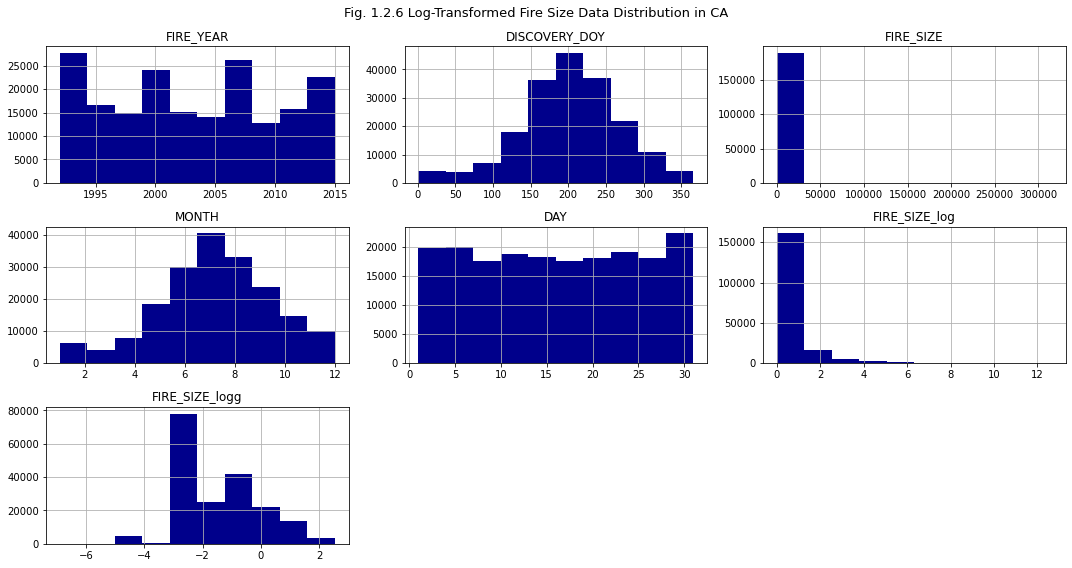

In [42]:
# As it makes no sense to plot them, we get rid of Latitude and Longitude for the histograms
df_CA_hist = df_CA[df_CA.columns.drop('LATITUDE')]
df_CA_hist = df_CA_hist[df_CA_hist.columns.drop('LONGITUDE')]

# Then we plot all remaining variables
df_CA_hist.hist(figsize=(15,8),color='darkblue');
plt.suptitle('Fig. 1.2.6 Log-Transformed Fire Size Data Distribution in CA', fontsize=13)
plt.subplots_adjust(top=0.88)
plt.tight_layout()

> This does not look perfect, but sufficient to work with.

We can now drop the unnecessary columns of FIRE_SIZE_log and STATE.

In [43]:
df_CA = df_CA[df_CA.columns.drop('FIRE_SIZE_log')]
df_CA = df_CA[df_CA.columns.drop('STATE')]

To get a better idea of the correlation between the variables we plot a correlation matrix. 

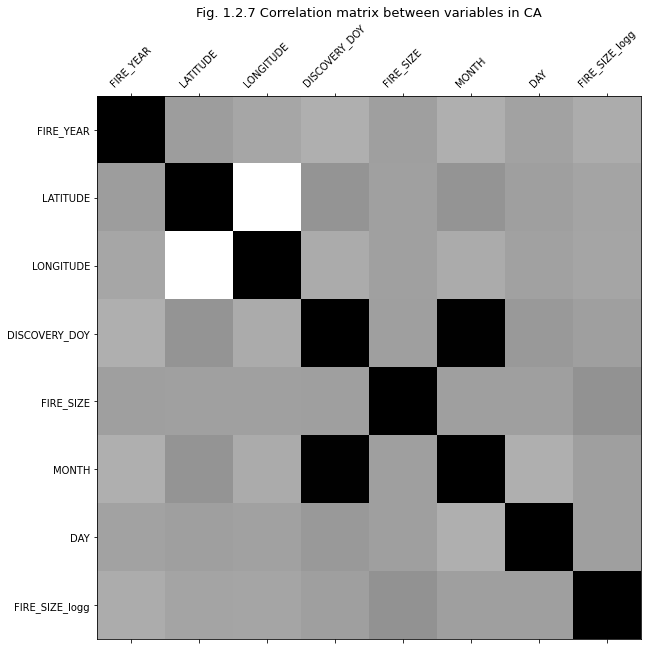

In [44]:
def plot_corr(df,size=10):
    corr = df_CA.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(corr,cmap=plt.cm.Greys)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    counter_fig='1.2.7'
    plt.title(f'Fig. {counter_fig} Correlation matrix between variables in CA', fontsize=13)
    plt.show()
    
plot_corr(df_CA)

> In the above diagram strong correlations are darker, while white indicates a zero correlation. There seems to be a correlation between month and latitude, perhaps related to weather and season. There is no obvious correlation between Fire_Size and any other variable.  

#### Further Exploration of Season and Fires 

While meteorological data holds a whole richer ensemble in variables and potential predictors for fire occurrence and size, we wanted to see whether the data available in our dataset could already give us some hints on the connection between fires and climate.

Firstly, we want to look at the monthly frequency of Fire Events in California.

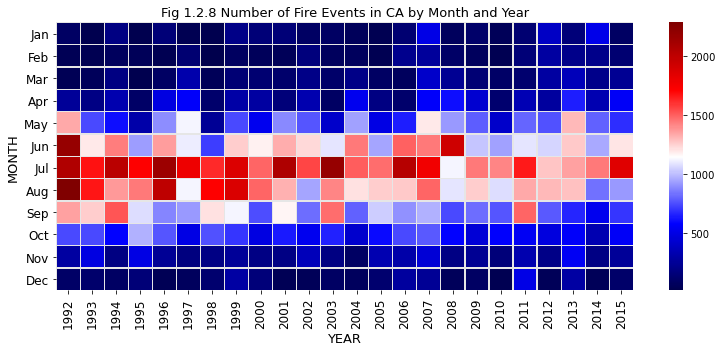

In [45]:
# plot monthly frequency of fire events
df_CA_freq_mon = df_CA.groupby(['MONTH', 'FIRE_YEAR']).size().unstack()
counter_fig = '1.2.8'
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_CA_freq_mon, cmap='seismic', linewidth=.2, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('YEAR', fontsize=13)
plt.ylabel('MONTH', fontsize=13)
plt.title(f'Fig {counter_fig} Number of Fire Events in CA by Month and Year', fontsize=13)
plt.tight_layout()

> We can already see that fires are more common during the summer months, roughly between May and September. This indicates a link between fires and meteorological features. Nevertheless, we expected that the number of fires would have increased significantly within the last years in due consideration of global warming. This heatmap, however, indicates that the number of fires has been going down. In an earlier section we examined this and found our expectation to be true for the total size of fires across the whole of the Unites States. <br> A speculative reason for the development seen here however, could be more awareness within the public and more caution when being in the wild.

We proceeded to investigate whether the causes of fires changed over the years as well.

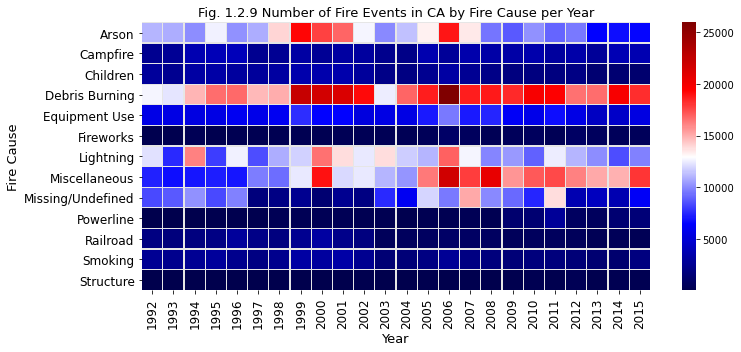

In [46]:
# plot fire frequency by cause and year
df_CA_freq_cause_year = df.groupby(['STAT_CAUSE_DESCR','FIRE_YEAR']).size().unstack()
counter_fig ='1.2.9'
plt.figure(figsize=[11,5])
sns.heatmap(df_CA_freq_cause_year, cmap='seismic', linewidth=.2, linecolor=[.9,.9,.9])
plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('Year', fontsize=13)
plt.ylabel('Fire Cause', fontsize=13)
plt.title(f'Fig. {counter_fig} Number of Fire Events in CA by Fire Cause per Year', fontsize=13)
plt.tight_layout()

> The thesis from above cannot really be confirmed: while there seems to be a decreasing trend in Arson, there are no trends to be identified in Campfires or Fireworks. Moreover, the trend in Debris Burning and Miscellaneous Fires has rather been increasing.

To better understand our data, we also tested how the frequency of fires was distributed throughout the year depending on its cause, to maybe spot some indications there as well. 

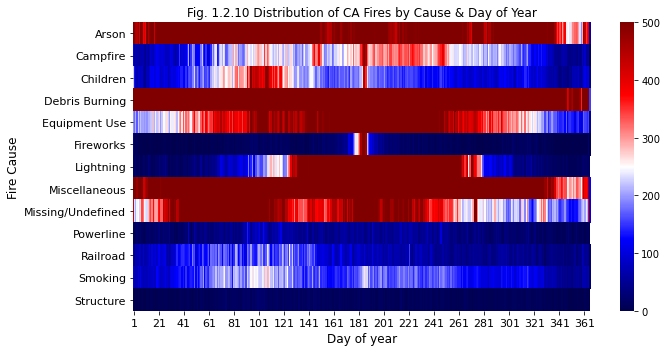

In [47]:
# plot fire frequency by cause and day of year
cause_by_date_of_year = df.groupby(['STAT_CAUSE_DESCR','DISCOVERY_DOY']).size().unstack()
counter_fig ='1.2.10'
plt.figure(figsize=[10,5])
ax = sns.heatmap(cause_by_date_of_year,cmap='seismic',vmin=0,vmax=500)
plt.xticks(np.arange(0.5,366.5,20), labels=range(1,366,20), rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Fire Cause', fontsize=12)
plt.xlabel('Day of year', fontsize=12)
plt.title(f'Fig. {counter_fig} Distribution of CA Fires by Cause & Day of Year')
plt.tight_layout()

> Here we can see that while some Fire Causes are equally common or rare throughout the year (e.g. Arson, Debris Burning, Powerline or Structure), others seem to be commenly linked to seasons (e.g. Campfires, Equipment Use, Fireworks and Lightning). 

Moreover, we looked at the the Fire Frequency depending on its cause and the day of the week:

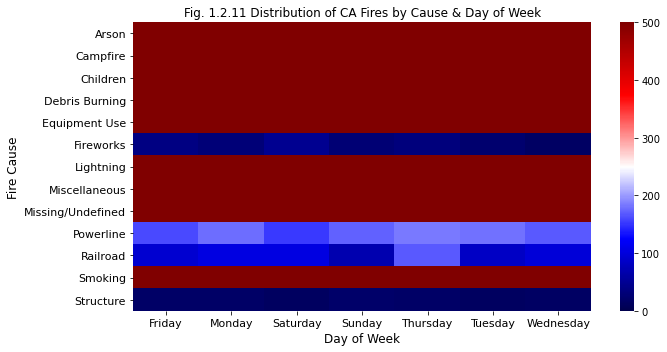

In [48]:
# plot fire frequency by cause and day of the week
cause_by_date_of_week = df_CA.groupby(['STAT_CAUSE_DESCR','DAY_OF_WEEK']).size().unstack()
counter_fig ='1.2.11'
plt.figure(figsize=[10,5])
ax = sns.heatmap(cause_by_date_of_week,cmap='seismic',vmin=0,vmax=500)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Fire Cause', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.title(f'Fig. {counter_fig} Distribution of CA Fires by Cause & Day of Week')
plt.tight_layout()

> This graph shows us that there are a few tendencies, e.g. Railroads causing fires being more common on a Thursday than on a Sunday, but in general this graph provides a good sanity check that causes like Lightning are not more common  on any day of the week - just as they should not be.

Next, we wanted to see whether there was a correspondence when looking at the total summed up FIRE_SIZE per month over the years:

In [49]:
df_CA_size_mon = pd.DataFrame(df_CA.groupby(['FIRE_YEAR','MONTH']).sum(), columns=['FIRE_SIZE']).unstack(level='FIRE_YEAR')
df_CA_size_mon

FIRE_SIZE                                                            \
FIRE_YEAR      1992      1993      1994     1995      1996      1997     1998   
MONTH                                                                           
1             222.3      45.1     876.7      5.4    4171.6       9.0     16.0   
2             225.5      28.0     163.9    197.7      28.0      93.4      3.4   
3            1885.4     211.1     315.1     28.5    1084.1    2401.3    152.1   
4            7364.5     762.8    6209.2    108.2   59488.3    3899.7    394.5   
5           12041.2   27252.2   11465.7   5296.1   34927.6   67569.7    852.2   
6           29892.0   48486.9   73749.2  35714.9   71224.0   14640.0   5062.5   
7           23378.3   20315.0   96740.1  52258.7   58928.6   21057.0  30164.4   
8          155138.0   28518.4  145753.4  67610.2  380980.2  133229.0  61398.5   
9           60516.0   53111.0   65992.3  15109.8   13117.0   28413.1   7482.4   
10           3897.1  127299.5    5819.0  34032.9   81980.5   52478.4  51778.9   
11           1735.9   14657.0     513.3   4959.7    1006.4     729.4   1428.3   
12            143.6     808.3     346.8    746.6     174.2      46.3   1279.9   

                                         ...                        \
FIRE_YEAR      1999      2000      2001  ...       2006       2007   
MONTH                                    ...                         
1             281.5     156.6   10890.9  ...     545.82    2283.13   
2            1460.0     110.8    2562.8  ...   13655.01     336.50   
3            2788.8    1802.6     329.2  ...      34.40    9841.74   
4            2006.3    2766.0     195.5  ...      47.74    4593.72   
5           17168.7    2991.7   11900.6  ...   11117.04   15694.16   
6           12505.2   16014.0   36630.3  ...   49135.62   27176.88   
7           42228.9  121903.2   38828.7  ...  403677.06  316140.08   
8          446104.7   80738.9  200698.6  ...   21084.94   20305.27   
9          180754.2   16120.6   34982.2  ...  229065.28  135061.67   
10          90945.6    8640.2   11064.0  ...   47262.51  506937.07   
11           1955.0     184.2     885.0  ...    2049.58    6701.34   
12           5924.5    1247.2    1208.9  ...   35036.94     220.06   

                                                                             \
FIRE_YEAR        2008       2009      2010      2011       2012        2013   
MONTH                                                                         
1              121.00     295.38    149.51    110.74     447.69     469.140   
2              588.85    1109.40      8.47    110.96     433.38     937.030   
3             1045.42     276.75    300.40   1321.98     378.98     407.580   
4             2782.37    4495.65     51.38    774.78     496.95    2123.090   
5            27504.04   16500.18   6844.42   6483.57   12219.44   93021.480   
6          1099737.24   12939.55   9336.63  19169.09   16476.87   11807.521   
7           130400.61   33323.56  73566.06  50432.55  158454.93  103476.260   
8            69680.20  347230.37  14058.27  25184.60  526512.86  346462.351   
9            23555.14   24710.64  13264.72  82314.93   47086.19   14503.020   
10           30871.28   13809.38   2581.80   3213.89    1459.65    2745.890   
11           43806.78     566.13    729.92   1190.09     771.85    4949.050   
12              60.67      93.05     55.46   1979.74      27.85     507.880   

                                 
FIRE_YEAR       2014       2015  
MONTH                            
1            5496.55     108.42  
2             227.08    7408.26  
3             874.52     154.10  
4            2987.21    9404.13  
5           26439.63    1627.43  
6           11960.26   80015.48  
7          244880.39  509513.40  
8          146469.39   83660.40  
9          103253.38  152028.38  
10           3977.79    2885.36  
11            276.35     571.72  
12             36.23    1351.53  

[12 rows x 24 columns]

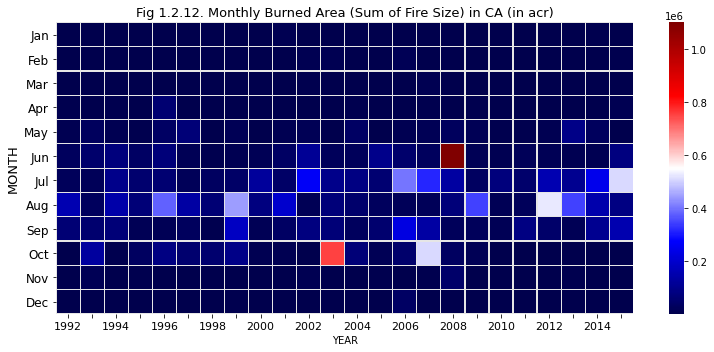

In [50]:
# plot monthly fire size
counter_fig = '1.2.12'
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
year_ticks = ['1992', ' ','1994', ' ','1996', ' ','1998', ' ','2000', ' ', '2002', ' ','2004', ' ', '2006', ' ','2008', ' ', '2010', ' ','2012', ' ', '2014', ' ']
plt.figure(figsize=[11,5])
sns.heatmap(df_CA_size_mon, cmap='seismic', linewidth=.2, linecolor=[.9,.9,.9])
##sns.heatmap(df_CA['FIRE_SIZE_logg'], cmap='seismic', linewidth=.2, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(np.arange(0.5,24.5), labels=year_ticks,rotation=0, fontsize=11,);
plt.xlabel('YEAR')
plt.ylabel('MONTH', fontsize=13)
plt.title(f'Fig {counter_fig}. Monthly Burned Area (Sum of Fire Size) in CA (in acr)', fontsize=13)
plt.tight_layout()

> We can see that the monthly area burned by fires is generally larger during the summer months between May and October. The largest areas by far were burned in October 2003 and June 2008.

Here, in our future endevours on the project we hope to plot the spatial distribution of all recorded wildfires in California on an interactive leaflet map by applying the folium environment.

 ## Part 2: Data Loading and Exploration - Weather
 
 ### Part 2.1: NOAA Weather Data

As we are interested in the effect of weather data, we now need to combine, clean and incorporate this weather data. This first data set was taken from NOAA, but as gathering the data is a demanding job, it only covers two stations (Eureka & Avalon) for trial reasons. 

In [51]:
cal_001 = pd.read_csv('C:\\Users\\avrol\\Desktop\\Data\\Weather\\NOAA-Fail\\2706211.csv')
# print(cal_001.head())
cal_002 = pd.read_csv('C:\\Users\\avrol\\Desktop\\Data\\Weather\\NOAA-Fail\\2706213.csv')
cal_003 = pd.read_csv('C:\\Users\\avrol\\Desktop\\Data\\Weather\\NOAA-Fail\\2706217.csv')
cal_004 = pd.read_csv('C:\\Users\\avrol\\Desktop\\Data\\Weather\\NOAA-Fail\\2706223.csv')
cal_005 = pd.read_csv('C:\\Users\\avrol\\Desktop\\Data\\Weather\\NOAA-Fail\\2706225.csv')

C:\Users\avrol\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,19,25,27,29,31,32,34,36,37,41,42,43,44,46,49,50,51,52,54,56,58,59,71,72,88,95,96,97,98,99,100,101,102,103,104,105,106,107) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\avrol\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,19,25,27,28,29,30,31,35,36,41,42,43,46,48,49,50,51,52,53,55,56,58,59,60,61,63,77,82,95,111,112,113,114,115,117,118,119) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\avrol\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,19,25,26,27,28,29,35,36,41,42,43,48,51,53,55,56,58,59,63,69,71,95,110,114,117,119,123) have mixed types.Specify dtype option on import or set low_memory=False

Next we need to make sure all data has the same format

In [52]:
print(">>>>>>>>>>>>> Cal_001")
print(cal_001.info())
print(cal_001.shape)
print(cal_001.dtypes)

print("\n","\n",">>>>>>>>>>>>> Cal_002")
print(cal_002.info())
print(cal_002.shape)
print(cal_002.dtypes)

print("\n","\n",">>>>>>>>>>>>> Cal_003")
print(cal_003.info())
print(cal_003.shape)
print(cal_003.dtypes)

print("\n","\n",">>>>>>>>>>>>> Cal_004")
print(cal_004.info())
print(cal_004.shape)
print(cal_004.dtypes)

print("\n","\n",">>>>>>>>>>>>> Cal_005")
print(cal_005.info())
print(cal_005.shape)
print(cal_005.dtypes)


>>>>>>>>>>>>> Cal_001
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141032 entries, 0 to 141031
Columns: 124 entries, STATION to WindEquipmentChangeDate
dtypes: float64(78), int64(1), object(45)
memory usage: 133.4+ MB
None
(141032, 124)
STATION                                 int64
DATE                                   object
REPORT_TYPE                            object
SOURCE                                 object
AWND                                  float64
                                       ...   
ShortDurationPrecipitationValue180    float64
Sunrise                               float64
Sunset                                float64
TStorms                               float64
WindEquipmentChangeDate                object
Length: 124, dtype: object

 
 >>>>>>>>>>>>> Cal_002
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165765 entries, 0 to 165764
Columns: 124 entries, STATION to WindEquipmentChangeDate
dtypes: float64(60), int64(1), object(63)
memory usage: 156.8+ M

Next we want to combine all station data in one df 'cal'

In [53]:
frames = [cal_001, cal_002, cal_003, cal_004, cal_005]
  
cal = pd.concat(frames)
display(cal)

,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,...,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,TStorms,WindEquipmentChangeDate
0,72594524283,1992-01-01T00:00:00,SAO,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-01-31
1,72594524283,1992-01-01T01:00:00,SAO,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-01-31
2,72594524283,1992-01-01T02:00:00,SAO,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-01-31
3,72594524283,1992-01-01T03:00:00,SAO,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-01-31
4,72594524283,1992-01-01T04:00:00,SAO,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120222,72292023191,2011-12-31T21:51:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120223,72292023191,2011-12-31T22:51:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120224,72292023191,2011-12-31T23:51:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120225,72292023191,2011-12-31T23:59:00,SOD,6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,657.0,1656.0,NaN,NaN


Due to the high number of columns, we need to identify them.

In [54]:
print(cal.columns.values)

['STATION' 'DATE' 'REPORT_TYPE' 'SOURCE' 'AWND' 'BackupDirection'
 'BackupDistance' 'BackupDistanceUnit' 'BackupElements' 'BackupElevation'
 'BackupElevationUnit' 'BackupEquipment' 'BackupLatitude'
 'BackupLongitude' 'BackupName' 'CDSD' 'CLDD' 'DSNW'
 'DailyAverageDewPointTemperature' 'DailyAverageDryBulbTemperature'
 'DailyAverageRelativeHumidity' 'DailyAverageSeaLevelPressure'
 'DailyAverageStationPressure' 'DailyAverageWetBulbTemperature'
 'DailyAverageWindSpeed' 'DailyCoolingDegreeDays'
 'DailyDepartureFromNormalAverageTemperature' 'DailyHeatingDegreeDays'
 'DailyMaximumDryBulbTemperature' 'DailyMinimumDryBulbTemperature'
 'DailyPeakWindDirection' 'DailyPeakWindSpeed' 'DailyPrecipitation'
 'DailySnowDepth' 'DailySnowfall' 'DailySustainedWindDirection'
 'DailySustainedWindSpeed' 'DailyWeather' 'HDSD' 'HTDD' 'HeavyFog'
 'HourlyAltimeterSetting' 'HourlyDewPointTemperature'
 'HourlyDryBulbTemperature' 'HourlyPrecipitation'
 'HourlyPresentWeatherType' 'HourlyPressureChange'
 'HourlyPres

Now we need to delete unnecessary columns to tidy up the data frame

In [55]:
# Containing  the words 'Monthly', 'Hourly', ShortDuration', 'Bulb', 'Pressure', 'Normals'
cal = cal[cal.columns.drop(list(cal.filter(regex='Monthly')))]
cal = cal[cal.columns.drop(list(cal.filter(regex='Hourly')))]
cal = cal[cal.columns.drop(list(cal.filter(regex='ShortDuration')))]
cal = cal[cal.columns.drop(list(cal.filter(regex='Bulb')))]
cal = cal[cal.columns.drop(list(cal.filter(regex='Pressure')))]
cal = cal[cal.columns.drop(list(cal.filter(regex='Normals')))]

# Delete the last ten columns as well
cal = cal.iloc[:, :-10]

# Delete "Backup" columns as well
cal.drop(cal.iloc[:, 5:12], inplace = True, axis = 1)

# Delete BackupName, CDSD, CLDD & DSNW
cal.drop(cal.iloc[:, 7:11], inplace = True, axis = 1)

# Also delete Report_Type, Source and AWND
cal.drop(cal.iloc[:, 2:5], inplace = True, axis = 1)

In [56]:
# Check dataframe again
print(cal.shape)
print(cal.columns.values)

(545606, 18)
['STATION' 'DATE' 'BackupLatitude' 'BackupLongitude'
 'DailyAverageDewPointTemperature' 'DailyAverageRelativeHumidity'
 'DailyAverageWindSpeed' 'DailyCoolingDegreeDays'
 'DailyDepartureFromNormalAverageTemperature' 'DailyHeatingDegreeDays'
 'DailyPeakWindDirection' 'DailyPeakWindSpeed' 'DailyPrecipitation'
 'DailySnowDepth' 'DailySnowfall' 'DailySustainedWindDirection'
 'DailySustainedWindSpeed' 'DailyWeather']


#### Data Investigation

General investigation of the dataframe from NOAA.

In [57]:
print(cal.head())

       STATION                 DATE  BackupLatitude  BackupLongitude  \
0  72594524283  1992-01-01T00:00:00             NaN              NaN   
1  72594524283  1992-01-01T01:00:00             NaN              NaN   
2  72594524283  1992-01-01T02:00:00             NaN              NaN   
3  72594524283  1992-01-01T03:00:00             NaN              NaN   
4  72594524283  1992-01-01T04:00:00             NaN              NaN   

   DailyAverageDewPointTemperature  DailyAverageRelativeHumidity  \
0                              NaN                           NaN   
1                              NaN                           NaN   
2                              NaN                           NaN   
3                              NaN                           NaN   
4                              NaN                           NaN   

   DailyAverageWindSpeed DailyCoolingDegreeDays  \
0                    NaN                    NaN   
1                    NaN                    NaN   
2    

> There is a lot of NaN values!

We need to check whether there is a lot of missing data in our dataframe.

In [58]:
print(cal.isnull().sum())

STATION                                            0
DATE                                               0
BackupLatitude                                545606
BackupLongitude                               545606
DailyAverageDewPointTemperature               545606
DailyAverageRelativeHumidity                  545606
DailyAverageWindSpeed                         534578
DailyCoolingDegreeDays                        533237
DailyDepartureFromNormalAverageTemperature    539997
DailyHeatingDegreeDays                        533237
DailyPeakWindDirection                        534780
DailyPeakWindSpeed                            533195
DailyPrecipitation                            533624
DailySnowDepth                                543086
DailySnowfall                                 543554
DailySustainedWindDirection                   534560
DailySustainedWindSpeed                       533195
DailyWeather                                  537084
dtype: int64


In [59]:
lencal = len(cal)
print(lencal)

545606


> Okay, yes, there is far too much missing data. We don't think the trial dataset can be used at all, unfortunately! And moreover, obtaining more data of this kind is not really worth it either, looking at the relation of work/time input and data output.

### Part 2.2: ERA5 Weather Data (Copernicus)

After finding the ERA dataset (https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview), understanding how to open, read and aggregate this file type and its components took us a very long time, especially as additional packages had to be installed in the conda environment first, that we were not aware of in the beginning. Additional hours of error messages were then uncovered to be due to wrongly downloaded data with East and West Longitudes being confused ... Nevertheless, we found a way to load and convert the data by closely working according to this article: https://www.linkedin.com/pulse/ai-climate-data-predicting-fire-frequency-california-ali-ahmadalipour/. 

In [60]:
df_era = xr.open_dataset('C:\\Users\\avrol\\Desktop\\Data\\ERA_climatedata_cali.nc').load()

In [61]:
df_era

<xarray.Dataset>
Dimensions:    (longitude: 37, latitude: 39, time: 288)
Coordinates:
  * longitude  (longitude) float32 -124.0 -123.8 -123.5 ... -115.5 -115.2 -115.0
  * latitude   (latitude) float32 42.0 41.75 41.5 41.25 ... 33.0 32.75 32.5
  * time       (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-01
Data variables:
    si10       (time, latitude, longitude) float32 2.762 2.166 ... 2.501 2.783
    d2m        (time, latitude, longitude) float32 276.3 273.6 ... 267.9 267.4
    t2m        (time, latitude, longitude) float32 279.5 277.0 ... 286.2 286.1
    pev        (time, latitude, longitude) float32 -0.0003893 ... -0.003075
    stl1       (time, latitude, longitude) float32 278.3 275.9 ... 285.9 286.4
    stl2       (time, latitude, longitude) float32 278.0 275.8 ... 288.9 288.6
    slt        (time, latitude, longitude) float32 2.0 2.0 4.0 ... 3.0 4.0 4.0
    tp         (time, latitude, longitude) float32 0.006227 ... 7.446e-05
    tvh        (time, latitude, longitude) float32 3.0 3.0 3.0 ... 18.0 18.0
    tvl        (time, latitude, longitude) float32 10.0 10.0 0.0 ... 11.0 10.0
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-12 15:15:55 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

The dataset hold the following variables

    - 10m wind speed (si10): 
            Horizontal speed of the wind at a height of ten metres above the surface of the Earth. 
            The units of this parameter are metres per second
            
    - 2m dewpoint temperature (d2m):
            Temperature to which the air, at 2 metres above the surface of the Earth, would have 
            to be cooled for saturation to occur. It is a measure of the humidity of the air.
            This parameter has units of kelvin (K).
            
    - 2m temperature (t2m):  
             Temperature of air at 2m above the surface of land, sea or inland waters. 
             This parameter has units of kelvin (K).
             
    - Potential evaporation (pev): 
            Measure of the extent to which near-surface atmospheric conditions are conducive to the 
            process of evaporation.
            
    - Soil temperature level 1 (stl1):
            Temperature of the soil at level 1 (in the middle of layer 1). The ECMWF Integrated 
            Forecasting System (IFS) has a four-layer representation of soil, where the surface 
            is at 0cm: Layer 1: 0 - 7cm. This parameter has units of kelvin (K).
            
    - Soil temperature level 2 (stl2): 
            Temperature of the soil at level 2 (in the middle of layer 2). The ECMWF Integrated 
            Forecasting System (IFS) has a four-layer representation of soil, where the surface 
            is at 0cm: Layer 2: 7 - 28cm. This parameter has units of kelvin (K).
            
    - Soil type (slt): 
            Texture (or classification) of soil used by the land surface scheme of the ECMWF 
            Integrated Forecasting System (IFS) to predict the water holding capacity of soil 
            in soil moisture and runoff calculations: 
                    1: Coarse, 
                    2: Medium, 
                    3: Medium fine, 
                    4: Fine, 
                    5: Very fine, 
                    6: Organic, 
                    7: Tropical organic. 
            A value of 0 indicates a non-land point.
    
    - Total precipitation (tp):  
            Accumulated liquid and frozen water, comprising rain and snow, that falls to the Earth's 
            surface. It is the sum of large-scale precipitation and convective precipitation.
    
    - Type of high vegetation (tvh):  
            This parameter indicates the 6 types of high vegetation recognised by the ECMWF 
            Integrated Forecasting System: 
                    3 = Evergreen needleleaf trees, 
                    4 = Deciduous needleleaf trees, 
                    5 = Deciduous broadleaf trees, 
                    6 = Evergreen broadleaf trees, 
                    18 = Mixed forest/woodland, 
                    19 = Interrupted forest. 
            A value of 0 indicates a point without high vegetation, including an oceanic or inland 
            water location. Vegetation types are used to calculate the surface energy balance and 
            snow albedo. This parameter does not vary in time.
            
    - Type of low vegetation (tvl): 
            This parameter indicates the 10 types of low vegetation recognised by the ECMWF 
            Integrated Forecasting System: 
                    1 = Crops, Mixed farming, 
                    2 = Grass, 
                    7 = Tall grass, 
                    9 = Tundra, 
                    10 = Irrigated crops, 
                    11 = Semidesert, 
                    13 = Bogs and marshes, 
                    16 = Evergreen shrubs, 
                    17 = Deciduous shrubs, 
                    20 = Water and land mixtures. 
            A value of 0 indicates a point without low vegetation, including an oceanic or inland 
            water location. Vegetation types are used to calculate the surface energy balance and 
            snow albedo. This parameter does not vary in time.

In [62]:
# Load California mask file
CA_mask = xr.open_dataset('C:\\Users\\avrol\\Desktop\\Data\\CA_mask.nc', engine='netcdf4').lsm.load()
# CA_mask

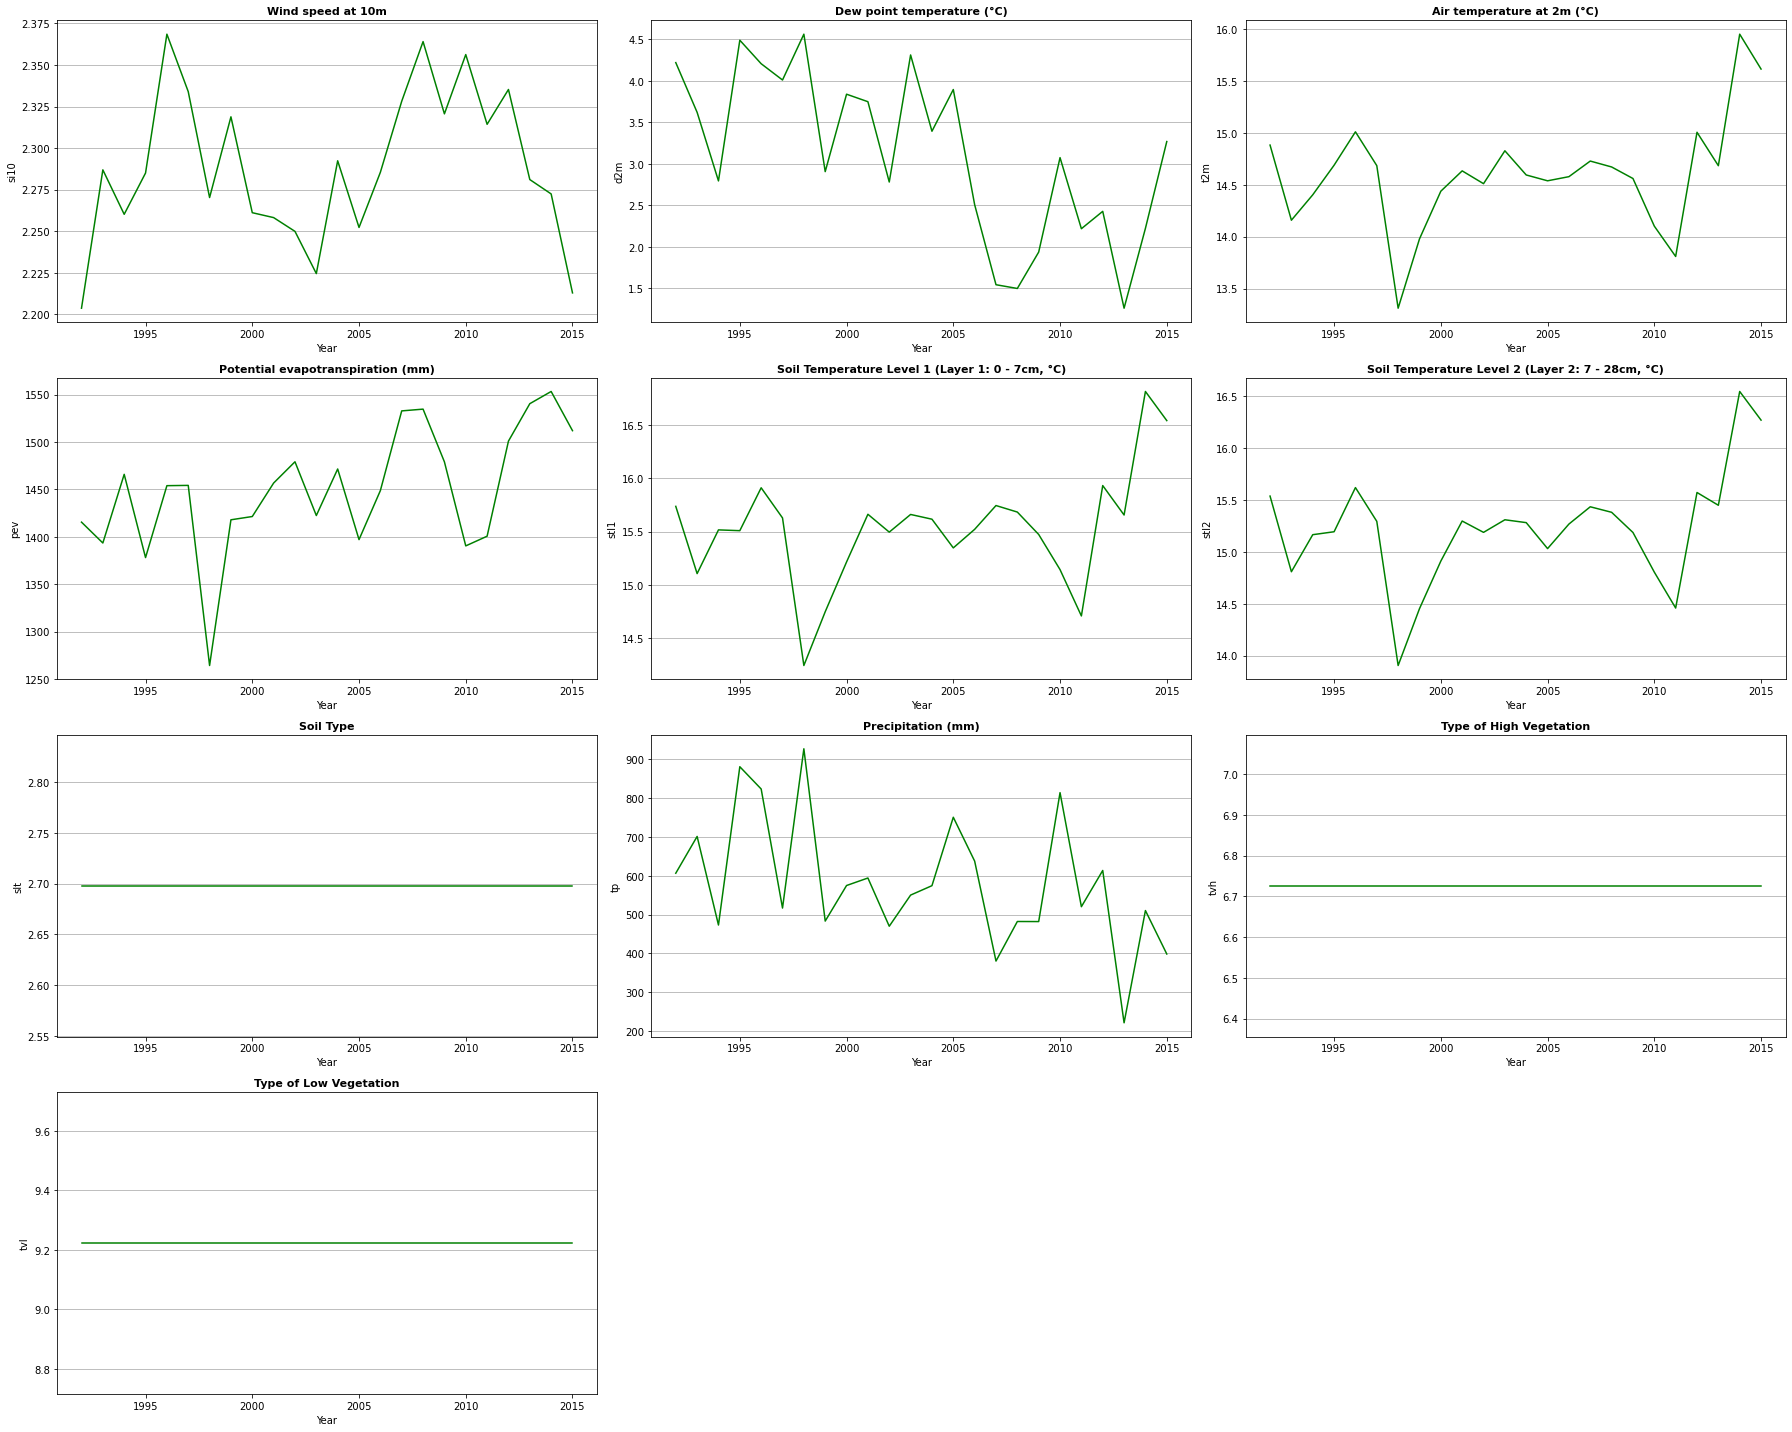

In [63]:
##### 5. Assessing climate trends #####
# plot climate trends
var = list(df_era.data_vars)
titles = {"tp":"Precipitation (mm)",
         "t2m":"Air temperature at 2m (°C)",
         "d2m":"Dew point temperature (°C)",
         "si10":"Wind speed at 10m",
         "stl1":"Soil Temperature Level 1 (Layer 1: 0 - 7cm, °C)",
         "stl2":"Soil Temperature Level 2 (Layer 2: 7 - 28cm, °C)",
         "slt":"Soil Type",
         "tvh":"Type of High Vegetation",
         "tvl":"Type of Low Vegetation",
         "pev":"Potential evapotranspiration (mm)"}
unit_conversion = {"tp": [1000*365,0], #convert default units to mm and °C -->[*multiply, *add]
                   "t2m": [1,-273.15], 
                   "d2m": [1,-273.15],
                   "si10": [1,0],
                   "stl1": [1,-273.15], 
                   "stl2": [1,-273.15],
                   "slt": [1,0],
                   "tvh": [1,0],
                   "tvl": [1,0],
                   "pev": [-1000*365,0]}
fig = plt.figure(figsize=(25, 20))
gs = gridspec.GridSpec(4, 3) 
for i in range(len(var)):
    plt.subplot(gs[i])
    (df_era[var[i]].where(CA_mask).mean(['latitude','longitude']).groupby(df_era.time.dt.year).mean()*unit_conversion[var[i]][0] + \
        unit_conversion[var[i]][1]).plot(color='g')
    plt.xlabel('Year')
    plt.grid(axis='y')
    plt.title(titles[var[i]], fontsize=11, fontweight='bold')
plt.tight_layout()

In [64]:
##### 6. Assessing the climate factors affecting fires #####
df_freq = pd.DataFrame(df_CA.groupby(['FIRE_YEAR','MONTH']).size(), columns=['Frequency'])
df_freq = df_freq.reset_index().rename(columns={'FIRE_YEAR':'Year', 'MONTH':'Month'})
# extract monthly ERA5 data
def extract_era5_yr_mon(yr, mon, var):
    unit_conversion = {"tp": [1000*30,0], #convert default units to mm and °C -->[*multiply, +add]
                       "t2m": [1,-273.15], 
                       "d2m": [1,-273.15],
                       "si10": [1,0],
                       "stl1": [1,-273.15], 
                       "stl2": [1,-273.15],
                       "slt": [1,0],
                       "tvh": [1,0],
                       "tvl": [1,0],
                       "pev": [-1000*365,0]}
    ds_yr_mon = df_era.sel(time = df_era.time.dt.month.isin(mon) & df_era.time.dt.year.isin(yr))
    output = float(ds_yr_mon[var].where(CA_mask).mean(['latitude','longitude']).values) * \
    unit_conversion[var][0] + unit_conversion[var][1]
    return output

# adding climate data to the dataframe
for i in range(len(var)):
    df_freq[var[i]] = df_freq.apply(lambda x: extract_era5_yr_mon(x.Year, x.Month, var[i]), axis=1)

#### Data Investigation


After combining the two datasets into a monthly average format, we can now finally check the Copernicus data.

In [65]:
df_freq.head()

,Year,Month,Frequency,si10,d2m,t2m,pev,stl1,stl2,slt,tp,tvh,tvl
0,1992,1,92,2.071129,-1.732764,5.343378,441.995675,5.245294,5.548395,2.697937,45.816908,6.72576,9.222896
1,1992,2,54,2.371276,2.880457,9.014581,590.634792,8.600183,8.084467,2.697937,148.346932,6.72576,9.222896
2,1992,3,48,2.045840,4.237177,10.215082,851.386702,10.543939,9.997095,2.697937,93.224924,6.72576,9.222896
3,1992,4,259,2.304967,4.234399,15.081903,1602.769780,15.435510,14.373407,2.697937,26.424568,6.72576,9.222896
4,1992,5,1339,2.244119,6.643304,19.482507,2186.972578,20.994928,19.810907,2.697937,10.332912,6.72576,9.222896


> Apparently, and we already saw this in the graphs above, our categorial variable Soil Type (slt), Type of High Vegetation (tvh) and Type of Low Vegetation (tvl) all hold the same value, due to averaging. 

As they are useless in this format and when looking at California as a whole, we can drop them for now and try to gather information from them in another way later. Moreover, we are going to rename the variables from the Copernicus Climate data for easier understanding.

In [66]:
df_freq.drop('slt',axis=1, inplace=True)
df_freq.drop('tvh',axis=1, inplace=True)
df_freq.drop('tvl',axis=1, inplace=True)

In [67]:
df_freq = df_freq.rename(columns={'si10':'Wind_Speed', 
                                  'd2m':'Dewpoint_Temp_2m',
                                  't2m':'Temperature_2m', 
                                  'pev':'Potential_Evaporation',
                                  'stl1':'Soil_Temp_1',
                                  'stl2':'Soil_Temp_2',
                                  'tp':'Percipitation'
                                 })

In [68]:
df_freq.shape

(288, 10)

> Unfortunately, our data is very few following the approach we chose now. But as obtaining valuable and fitting climate data really was a huge struggle, we at least want to try and see what we can achive with the datapoints we got.

Another checkup we wanted to regularly perform with the dataset was to see whether it was complete or missing any further values.

In [69]:
print(df_freq.isnull().sum())

Year                     0
Month                    0
Frequency                0
Wind_Speed               0
Dewpoint_Temp_2m         0
Temperature_2m           0
Potential_Evaporation    0
Soil_Temp_1              0
Soil_Temp_2              0
Percipitation            0
dtype: int64


> Fortunately, the data we got now is not missing any values.

### Exploration of Copernicus Climate Data

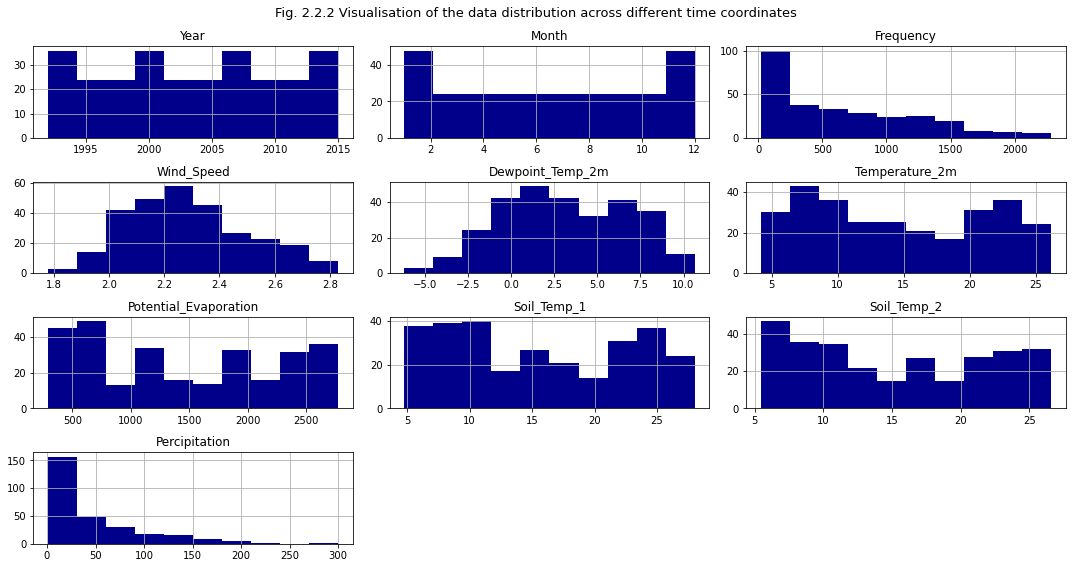

In [70]:
df_freq.hist(figsize=(15,8),color='darkblue')
plt.suptitle('Fig. 2.2.2 Visualisation of the data distribution across different time coordinates', fontsize=13)
plt.subplots_adjust(top=0.88)
plt.tight_layout()

> It's clearly visible that most scales are not normally distributed, and especially Fire Frequency and Pericipitation are very skrewed. We should think about log-transforming those two, and we need to scale all variables for our machine learning approach.

Next we wanted to check the correlations between our variables again, also to get a first idea what climate variables might be linked to Fire Frequency and therefore could be potentially good predictors.

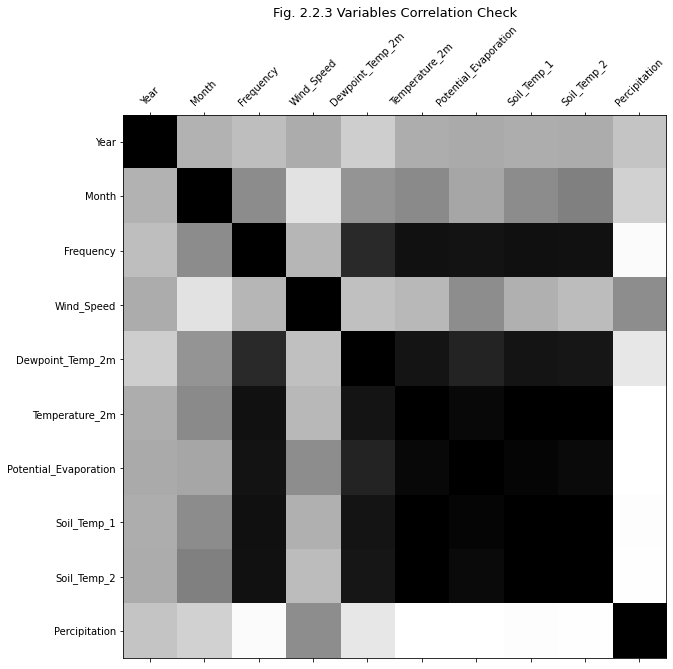

In [71]:
def plot_corr(df,size=10):
    corr = df_freq.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(corr,cmap=plt.cm.Greys)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45) 
    counter_fig='2.2.3'
    plt.title(f'Fig. {counter_fig} Variables Correlation Check', fontsize=13)
    plt.show()
    
plot_corr(df_freq)

> Looks like a few variables are highly correlated with Frequency of Fires and could therefore prove to be valueable in our ML model! <br> Namely, these are:

    - Dewpoint Temperature (at 2m)
    - Temperature (at 2m)
    - Potential Evaporation
    - Soil Temperature at Level 1
    - Soil Temperature at Level 2
    
Interestingly, percipitation does not seem to have a correlation with frequency of fires at all.

C:\Users\avrol\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\avrol\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


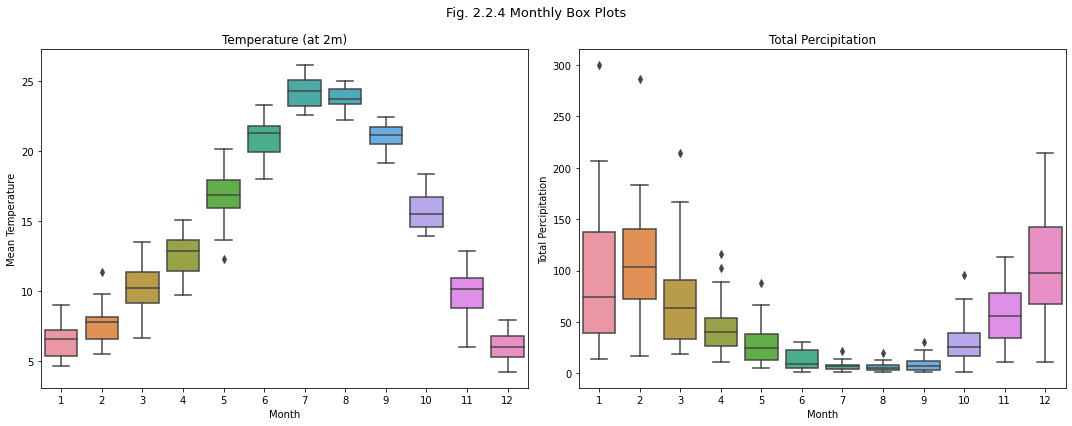

In [72]:
# box plot to check the mean temp & forecasted mean temp seasonality wrt month
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

sns.boxplot(df_freq["Month"], df_freq["Temperature_2m"], ax = ax[0])
ax[0].set_title("Temperature (at 2m)")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Mean Temperature")

sns.boxplot(df_freq["Month"], df_freq["Percipitation"], ax = ax[1])
ax[1].set_title("Total Percipitation")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Total Percipitation")

fig.tight_layout()
fig.suptitle('Fig. 2.2.4 Monthly Box Plots', fontsize=13)
fig.subplots_adjust(top=0.88)
plt.show()

To even further improve the visualization, we plan to keep working here in order plot all the temperature variables as multiple lines in one linegraph.

## Part 3: Machine Learning


### Part 3.1: Predicting Fire Size [& Frequency] with Fire Data only

**FIRE SIZE**
The first goal is to predict the size of fires. To do this, we will look at different features, foremost those that indirectly represent meteorological data, like MONTH or DISCOVERY_DOY (Day of Year). The code below can be (and has been) used to test how the in- or exclusion of different features influences the model performance.

But first, to prepare our data for ML, we convert all features to numeric values and drop the DATE field as well as drop any NAs.

In [73]:
# Convert categorical variables to numeric values
le = preprocessing.LabelEncoder()
df_CA['STAT_CAUSE_DESCR'] = le.fit_transform(df_CA['STAT_CAUSE_DESCR'])
df_CA['DAY_OF_WEEK'] = le.fit_transform(df_CA['DAY_OF_WEEK'])
#print(df_CA.head())

In [74]:
# Restore full dataset for ML & delete DATE and FIRE_SIZE
df_CA_ML = df_CA.drop('DATE',axis=1)
df_CA_ML = df_CA_ML.drop('FIRE_SIZE',axis=1) 
df_CA_ML = df_CA_ML.dropna()

# Drop all features of interest - those with a '#' will remain
df_CA_ML = df_CA_ML.drop('FIRE_YEAR',axis=1)
df_CA_ML = df_CA_ML.drop('STAT_CAUSE_DESCR',axis=1)
#df_CA_ML = df_CA_ML.drop('LATITUDE',axis=1)
#df_CA_ML = df_CA_ML.drop('LONGITUDE',axis=1)
#df_CA_ML = df_CA_ML.drop('DISCOVERY_DOY',axis=1)
#df_CA_ML = df_CA_ML.drop('MONTH',axis=1)
df_CA_ML = df_CA_ML.drop('DAY',axis=1)
df_CA_ML = df_CA_ML.drop('DAY_OF_WEEK',axis=1)

# Check which Features are left
df_CA_ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189550 entries, 0 to 1880464
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LATITUDE        189550 non-null  float64
 1   LONGITUDE       189550 non-null  float64
 2   DISCOVERY_DOY   189550 non-null  int64  
 3   MONTH           189550 non-null  int64  
 4   FIRE_SIZE_logg  189550 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 8.7 MB


In [75]:
# Create Features & Target
X = df_CA_ML.drop(['FIRE_SIZE_logg'], axis=1).values  
y = df_CA_ML['FIRE_SIZE_logg'].values 

# Scaling
scaler = StandardScaler() 
#scaler = MinMaxScaler() # Type of Scaler > does not really make a difference
X = scaler.fit_transform(X)

# Splitting Train and Test Set (20% for testing, 80% for training)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0) 

# Basic Linear Regression
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)
reg_all.score(X_test, y_test)
print('Coefficients of Determination (r2):', "\n", reg_all.score(X_test, y_test), "\n")

# Basic Linear Regression with 5-fold Cross Validation
reg = LinearRegression()
cv_results = cross_val_score(reg, X_train, y_train, cv=5)
print('Coefficients of Determination (r2) with 5-fold CV:', "\n",cv_results, "\n")
print('Mean Coefficient of Determination (r2) with 5-fold CV:', "\n", np.mean(cv_results))

Coefficients of Determination (r2): 
 0.01469782066600156 

Coefficients of Determination (r2) with 5-fold CV: 
 [0.01133735 0.01463618 0.01434843 0.00963186 0.01134458] 

Mean Coefficient of Determination (r2) with 5-fold CV: 
 0.012259680720424404


In [76]:
# What are the parameters of our regression line?
print('Intercept:', reg_all.intercept_)
print('Slope:', reg_all.coef_)

# Plot Linear Regression 
# >>> Unfortunaley this is not possible in a sensible way with the number of features selected.

Intercept: -1.2735916830094167
Slope: [-0.29844119 -0.29921796  0.09144895 -0.07836601]


> Despite several trials and combinations, it seems that the Fire Size is not a Target that can be predicted easily. <br> In the process of our project we found that the error in this approach originates from the log-transformation as this changes the target variable which cannot work.

**Conclusion:** FIRE_SIZE is not a target that can be predicted with the data we have so far. It will be better - and rather meeting our project goal - to look at the combined Fire & Weather data. There we will have information on whether there was a fire or not. Then we can calculated our planned Classifications (e.g. logisitic regression) to determine whether meteorological features can predicte a fire or its probability.


**Fire Frequency**

> We suspect this might not be doable as the lengths of target and features differ (per Month vs. per Fire).

In [77]:
# Convert categorical variables to numeric values
le = preprocessing.LabelEncoder()
df_CA['STAT_CAUSE_DESCR'] = le.fit_transform(df_CA['STAT_CAUSE_DESCR'])
df_CA['DAY_OF_WEEK'] = le.fit_transform(df_CA['DAY_OF_WEEK'])
#print(df_CA.head())

In [78]:
# Restore full dataset for ML & delete DATE and FIRE_SIZE
df_CA_ML_freq = df_CA.drop('DATE',axis=1)
df_CA_ML_freq = df_CA_ML_freq.drop('FIRE_SIZE',axis=1)
df_CA_ML_freq = df_CA_ML_freq.dropna()

# Drop all features of interest - those with a '#' will remain
#df_CA_ML_freq = df_CA_ML_freq.drop('STAT_CAUSE_DESCR',axis=1)
#df_CA_ML_freq = df_CA_ML_freq.drop('LATITUDE',axis=1)
#df_CA_ML_freq = df_CA_ML_freq.drop('LONGITUDE',axis=1)
df_CA_ML_freq = df_CA_ML_freq.drop('DAY',axis=1)
df_CA_ML_freq = df_CA_ML_freq.drop('DAY_OF_WEEK',axis=1)

# Check which Features are left
df_CA_ML_freq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189550 entries, 0 to 1880464
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   FIRE_YEAR         189550 non-null  int64  
 1   STAT_CAUSE_DESCR  189550 non-null  int64  
 2   LATITUDE          189550 non-null  float64
 3   LONGITUDE         189550 non-null  float64
 4   DISCOVERY_DOY     189550 non-null  int64  
 5   MONTH             189550 non-null  int64  
 6   FIRE_SIZE_logg    189550 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 11.6 MB


In [79]:
# Create Features & Target
X = df_CA_ML.drop(['FIRE_YEAR'], axis=1)#.values
fire_freq = pd.DataFrame(df_CA.groupby(['FIRE_YEAR','MONTH']).size(), columns=['Frequency']) 
y = fire_freq['Frequency'].values

# Scaling
scaler = StandardScaler() 
#scaler = MinMaxScaler() # Type of Scaler > does not really make a difference
X = scaler.fit_transform(X)

# Splitting Train and Test Set (20% for testing, 80% for training)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0) 

# Basic Linear Regression
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)
reg_all.score(X_test, y_test)
print('Coefficients of Determination (r2):', "\n", reg_all.score(X_test, y_test), "\n")

# Basic Linear Regression with 5-fold Cross Validation
reg = LinearRegression()
cv_results = cross_val_score(reg, X_train, y_train, cv=5)
print('Coefficients of Determination (r2) with 5-fold CV:', "\n",cv_results, "\n")
print('Mean Coefficient of Determination (r2) with 5-fold CV:', "\n", np.mean(cv_results))

KeyError: "['FIRE_YEAR'] not found in axis"

> The datasets are in fact not comparable, unfortunately. While fire frequency is aggregated per month, the features are given per fire. Aggregating them per month, e.g. causes or days of the week does not make sense at all.

### Part 3.2: Predicting Fires Size and Frequency with Fire & Weather Data

The main aim of our project was to use weather data to allow predictions on wildfires. As our weather data was consisting of monthly averages, no fine-grained predictions on a daily basis were possible. Nevertheless, we build models on a monthly basis that can produce insights in on-going research regarding climate change and its applications.

**Total Fire Size**

Our first approach to using Weather Data was again to predict the Fire Size. Other than before, this time we looked at the summed up Total Fire Size (in acres) over a month. Predicting how much land will be burned within a month can be a good indicator of the severeness of the fire situation. While we tried different features and combinations, we highlight within this code the one feature that worked best to also illustrate it with regression lines and residual plots.

In a first step, we decide which fires to include in the total monthly sum. Excluding small fires, e.g. smaller than 10 acres, can help to improve the model.

In [80]:
# Only look at fires greater in size than value s
df_CA_c = df_CA.drop('DATE',axis=1)
s = 10
df_CA_c['FIRE_SIZE'].values[df_CA_c['FIRE_SIZE'].values < s] = 0
#df_CA

In [81]:
#Calculate the sum of fire_sizes per month
df_CA_size_mon = pd.DataFrame(df_CA_c.groupby(['FIRE_YEAR','MONTH']).sum(), columns=['FIRE_SIZE']) #.unstack(level='FIRE_YEAR'
#df_CA_size_mon
#df_CA_size_mon['FIRE_SIZE']

In [82]:
# FEATURE SELECTION

# Copy df_freq to a new dataset so we don't need to calculate all cleaning steps from above again in 
# case we want to change and try new features or accidentally delete a column we wanted to keep.
df_freq_ML = df_freq

# Drop all features of interest - 
# Those with a '#' will remain!

df_freq_ML = df_freq_ML.drop('Year',axis=1)
df_freq_ML = df_freq_ML.drop('Month',axis=1)
df_freq_ML = df_freq_ML.drop('Wind_Speed',axis=1)
df_freq_ML = df_freq_ML.drop('Dewpoint_Temp_2m',axis=1)
#df_freq_ML = df_freq_ML.drop('Temperature_2m',axis=1)
df_freq_ML = df_freq_ML.drop('Potential_Evaporation',axis=1)
df_freq_ML = df_freq_ML.drop('Soil_Temp_1',axis=1)
df_freq_ML = df_freq_ML.drop('Soil_Temp_2',axis=1)
df_freq_ML = df_freq_ML.drop('Percipitation',axis=1)

# Check which Features are left
df_freq_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Frequency       288 non-null    int64  
 1   Temperature_2m  288 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.6 KB


In [83]:
# ML MODEL BUILDING & TESTING

# Create Features & Target
X = df_freq_ML.drop(['Frequency'], axis=1).values 
y = df_CA_size_mon['FIRE_SIZE'].values 

# Scaling
scaler = StandardScaler() 
#scaler = MinMaxScaler() # Type of Scaler > does not really make a difference here!
X = scaler.fit_transform(X)

# Splitting Train and Test Set (20% for testing, 80% for training)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0) 


# Basic Linear Regression 
reg_all = LinearRegression() 
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)
r_sq = reg_all.score(X_test, y_test)
print('Coefficient of Determination (r2):', "\n", r_sq, "\n") 

# Basic Linear Regression with 5-fold Cross Validation 
reg = LinearRegression()                               
cv_results = cross_val_score(reg, X_train, y_train, cv=5)
print('Coefficients of Determination (r2) with 5-fold CV:', "\n", cv_results, "\n")
print('Mean Coefficient of Determination (r2) with 5-fold CV:', "\n", np.mean(cv_results))

Coefficient of Determination (r2): 
 0.2980985516583117 

Coefficients of Determination (r2) with 5-fold CV: 
 [ 0.07721884 -0.33478335  0.13506445  0.14374433  0.11433571] 

Mean Coefficient of Determination (r2) with 5-fold CV: 
 0.02711599706980572


> The coefficients for this model have a very high variability.

Intercept: 44868.19397606928
Slope: [45044.73591444]


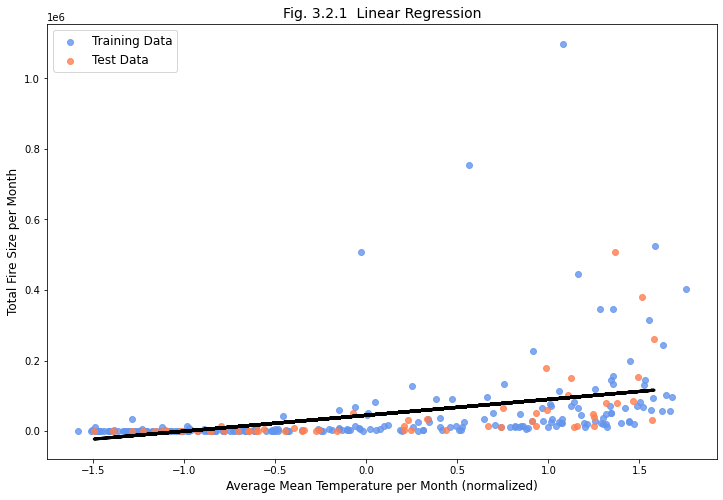

In [84]:
# What are the parameters of our regression line?
print('Intercept:', reg_all.intercept_)
print('Slope:', reg_all.coef_)

# Plot Linear Regression 
plt.figure(figsize=[12,8])
plt.scatter(X_train, y_train,  color='cornflowerblue', alpha =0.8, label='Training Data')
plt.scatter(X_test, y_test,  color='coral', alpha =0.8, label='Test Data')
plt.title('Fig. 3.2.1  Linear Regression',fontsize=14)
plt.xlabel('Average Mean Temperature per Month (normalized)',fontsize=12)
plt.ylabel('Total Fire Size per Month', fontsize=12)
plt.legend(loc="upper left",fontsize=12)

plt.plot(X_test, reg_all.predict(X_test), color='black',linewidth=3)

plt.show()

> Just like above, plotting makes only sense with a simple linear regression, here shown with the feature Temperature.

C:\Users\avrol\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


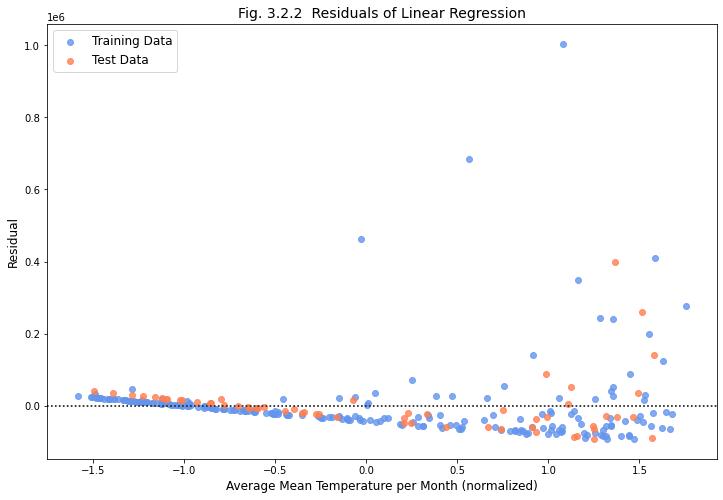

In [85]:
# Plot Residuals
fig =plt.figure(figsize=[12,8])
sns.residplot(X_train, y_train,  color='cornflowerblue', label='Training Data')
sns.residplot(X_test, y_test,  color='coral', label='Test Data')

plt.title('Fig. 3.2.2  Residuals of Linear Regression',fontsize=14)
plt.xlabel('Average Mean Temperature per Month (normalized)',fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.legend(loc="upper left",fontsize=12)

> Predicting a monthly total fire size with weather data was not very successful. Model coefficients are low and show a high variability. Visualisations show that our regression line is far from data points and residuals. As Fire Size was also hard to predict before in our first ML approach above due to the mentioned error we were able to identify but not solve in time. Clearly, it's own variability and skewed distribution will impact this difficulty as well.

**Fire Frequency**

Apart from Fire Size, we wanted to try and predict the monthly Frequency of Fires as well. By understanding which circumstances can cause a month to have more fires and predicting these "High Seasons", general caution measures can be taken and pre-warnings spread. While we tried different features and combinations, we highlight within this code the one feature that worked best to also illustrate it with regression lines and residual plots.

In [86]:
# FEATURE SELECTION

# Copy df_freq to a new dataset so we don't need to calculate all cleaning steps from above again in 
# case we want to change and try new features or accidentally delete a column we wanted to keep.
df_freq_ML = df_freq

# Drop all features of interest - 
# Those with a '#' will remain!

df_freq_ML = df_freq_ML.drop('Year',axis=1)
df_freq_ML = df_freq_ML.drop('Month',axis=1)
df_freq_ML = df_freq_ML.drop('Wind_Speed',axis=1)
df_freq_ML = df_freq_ML.drop('Dewpoint_Temp_2m',axis=1)
#df_freq_ML = df_freq_ML.drop('Temperature_2m',axis=1)
df_freq_ML = df_freq_ML.drop('Potential_Evaporation',axis=1)
df_freq_ML = df_freq_ML.drop('Soil_Temp_1',axis=1)
df_freq_ML = df_freq_ML.drop('Soil_Temp_2',axis=1)
df_freq_ML = df_freq_ML.drop('Percipitation',axis=1)

# Check which Features are left
df_freq_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Frequency       288 non-null    int64  
 1   Temperature_2m  288 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.6 KB


In [87]:
# ML MODEL BUILDING & TESTING

# Create Features & Target
X = df_freq_ML.drop(['Frequency'], axis=1).values 
y = df_freq_ML['Frequency'].values 

# Scaling
scaler = StandardScaler() 
#scaler = MinMaxScaler() # Type of Scaler > does not really make a difference here!
X = scaler.fit_transform(X)

# Splitting Train and Test Set (20% for testing, 80% for training)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0) 


# Basic Linear Regression 
reg_all = LinearRegression() 
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)
r_sq = reg_all.score(X_test, y_test)
print('Coefficient of Determination (r2):', "\n", r_sq, "\n") 

# Basic Linear Regression with 5-fold Cross Validation 
reg = LinearRegression()                               
cv_results = cross_val_score(reg, X_train, y_train, cv=5)
print('Coefficients of Determination (r2) with 5-fold CV:', "\n", cv_results, "\n")
print('Mean Coefficient of Determination (r2) with 5-fold CV:', "\n", np.mean(cv_results))

Coefficient of Determination (r2): 
 0.7606695883282804 

Coefficients of Determination (r2) with 5-fold CV: 
 [0.8302521  0.84104967 0.80019619 0.79215638 0.80946965] 

Mean Coefficient of Determination (r2) with 5-fold CV: 
 0.814624797532977


Intercept: 657.6067136045704
Slope: [503.38726744]


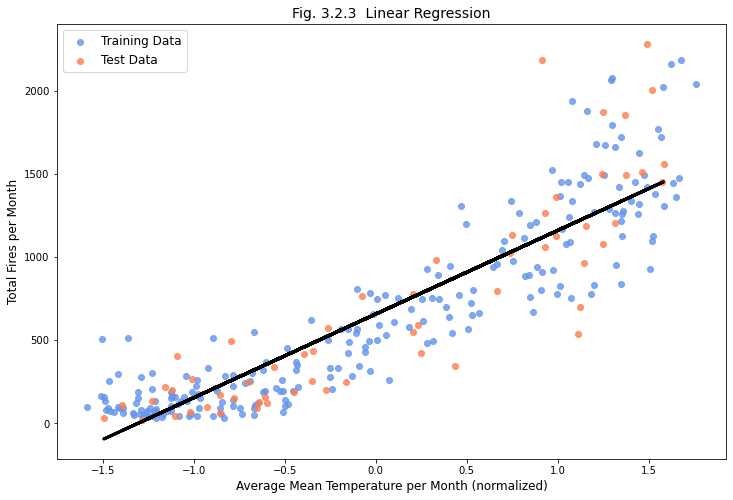

In [88]:
# What are the parameters of our regression line?
print('Intercept:', reg_all.intercept_)
print('Slope:', reg_all.coef_)

# Plot Linear Regression 
plt.figure(figsize=[12,8])
plt.scatter(X_train, y_train,  color='cornflowerblue', alpha =0.8, label='Training Data')
plt.scatter(X_test, y_test,  color='coral', alpha =0.8, label='Test Data')
plt.title('Fig. 3.2.3  Linear Regression',fontsize=14)
plt.xlabel('Average Mean Temperature per Month (normalized)',fontsize=12)
plt.ylabel('Total Fires per Month', fontsize=12)
plt.legend(loc="upper left",fontsize=12)

plt.plot(X_test, reg_all.predict(X_test), color='black',linewidth=3)

plt.show()

C:\Users\avrol\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


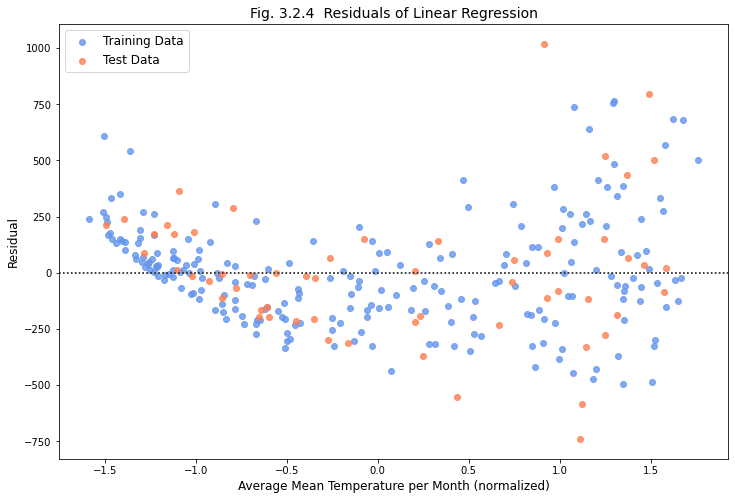

In [89]:
# Plot Residuals
fig =plt.figure(figsize=[12,8])
sns.residplot(X_train, y_train,  color='cornflowerblue', label='Training Data')
sns.residplot(X_test, y_test,  color='coral', label='Test Data')

plt.title('Fig. 3.2.4  Residuals of Linear Regression',fontsize=14)
plt.xlabel('Average Mean Temperature per Month (normalized)',fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.legend(loc="upper left",fontsize=12)

> While the residual errors show huge differences for some data points, all in all this final model yielded the best results. This can be seen in the relatively high and constant value of R2, where the 5-fold CV runs are indicating that even over several runs the results are fairly similar (not like before for Fire Size), as well as in the well-fitting regression line. What it shows us is that increasing temperatures there is a proportional increase of Fires per Month.

# Summary
In this project we analysed the wildfires in California using fire data and meteorological data.
We used the kaggle dataset "188 Million U.S. Wildfires" and extracted the meteorological data from NOAA and ERA5 (Copernicus). <br> The project was divided into 3 parts. In the first part we did exploratory data analysis of the fire data and in the following second part we did exploratory data analysis of the weather data. In the third and last section we applied linear regression models to predict the fires size and frequency with our fire & weather data. The analysis shows us that a high temperature is the dominating factor in the increase of fires per month.

# Outlook

To finish our project we'd like to give an outlook of the possibilities the project carries for the future.
<br> We would like to predict if there would be a wildfire on a specific day. To do so, we would look at the fire sizes and for startes only consider large and dangerous wildfire sizes, disregarding the smaller fires. <br> In a next step, the conditions under which these large wildfires occured would have to be investigated by connecting the input model to the data on soil, temperature, et cetera. To realize this idea, we will have to collect daily based data and implement it. <br> From our project, we were able to conclude that there is a lot to learn by the investigation and prediction of wildfires and that it is quite an important and just as promising area of research. 